<div style="text-align: center;">
    <h1> <font style="bold"> Analisis Predictivo Avanzado </font></h1>
    <h2><font style="bold">Trabajo práctico 2</font></h2>
    <h3><font style="bold">Integrantes:</font></h3>
</div>
<div style="display: flex; justify-content: center;">
    <h4><ul>
        <li>Noguera Abril</li>
        <li>Arbues Lucas</li>
        <li>Alfie Agustin</li>
        </ul>
    </h4>
</div>

Las plataformas de streaming ofrecen una gran cantidad de películas, lo que a menudo resulta en una elección difícil para los usuarios. Esta "Parálisis por Análisis" puede afectar negativamente la experiencia del usuario, disminuyendo el compromiso con la plataforma y aumentando las tasas de cancelación de suscripciones.

# Justificacion de Negocio

El sistema de recomendación de películas está diseñado para **mejorar la experiencia del usuario** mediante la facilitación de la elección de contenidos. El desafío radica en desarrollar un mecanismo que no solo se alinee con las preferencias individuales de los usuarios sino que también fomente el descubrimiento de nuevas películas que puedan ser de su interés, con el fin de aumentar su satisfacción y fidelidad a la plataforma.

<p align="center">
  <img src="imagenes/movierecommendation.png" alt="Movie Recommendation System" width="400"/>
</p>

Este Notebook se enfocará en el desarrollo de un sistema de recomendación de películas mediante el uso de técnicas avanzadas de machine learning. Se utilizarán algoritmos de filtrado colaborativo, metodos basados en memoria y metodos colaborativos para analizar los patrones de visualización, las calificaciones y los metadatos de las películas, con el objetivo de proporcionar recomendaciones precisas y personalizadas.

Se incluirá en el proyecto una fase de despliegue (deploy) que permitirá a los usuarios interactuar con el sistema de recomendación en un entorno operativo. Mediante una interfaz sencilla, los usuarios podrán ingresar su ID y el título de una película que les haya gustado para recibir recomendaciones personalizadas. Este enfoque asegura la transición del modelo desde el desarrollo hasta su aplicación práctica, donde su efectividad puede ser evaluada en términos de mejora en la experiencia del usuario.

Este Notebook documentará el proceso completo, desde la preparación de los datos hasta el despliegue operativo del sistema, sirviendo como una guía detallada para la implementación del sistema de recomendación y la evaluación de su rendimiento en un escenario real.

## Imports

In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import geopandas as gpd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
import math
import time
import random
import warnings
import difflib
from tabulate import tabulate
import plotly.express as px

# Surprise library imports
from surprise import Dataset, Reader
from surprise import SVD, SVDpp, NMF, SlopeOne, NormalPredictor
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise.prediction_algorithms import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import accuracy, dump

# Tus funciones personalizadas
from funciones import *

# Configuraciones
warnings.filterwarnings('ignore', category=DeprecationWarning)


# Preparacion de la Informacion

## Carga de Bases de Datos

In [2]:
movies = pd.read_csv("input/movies_metadata.csv", quotechar='"')

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_63925/3221149849.py:1: DtypeWarning: Columns (4,12) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv("input/movies_metadata.csv", quotechar='"')


## Preparacion de Datos

In [3]:
movies.columns

Index(['title', 'overview', 'release_date', 'vote_average', 'vote_count',
       'genres', 'id', 'original_language', 'popularity', 'adult', 'budget',
       'revenue', 'runtime', 'status', 'tagline', 'video',
       'belongs_to_collection', 'homepage', 'imdb_id', 'original_title',
       'poster_path', 'production_companies', 'production_countries',
       'spoken_languages'],
      dtype='object')

### Columnas

* **adult:** Indica si la pelicula es X-Rated o Adult.
* **belongs_to_collection:** Un diccionario que da informacion de la saga a la que la pelicula pertenece.
* **budget:** Presupuesto de la pelicula en dolares. 
* **genres:** Una lista en forma de texto de diccionarios que enumeran todos los géneros asociados con la película.
* **homepage:** La página oficial de la película.
* **id:** El ID de la película.
* **imdb_id:** El ID de IMDB de la película.
* **original_language:** El idioma en el que la película fue originalmente filmada.
* **original_title:** El título original de la película.
* **overview:** Una breve descripción de la película.
* **popularity:** La puntuación de popularidad asignada por TMDB.
* **poster_path:** La URL de la imagen del póster.
* **production_companies:** Una lista en forma de texto de las compañías de producción involucradas en la realización de la película.
* **production_countries:** Una lista en forma de texto de los países donde la película fue rodada/producida.
* **release_date:** Fecha de lanzamiento teatral de la película.
* **revenue:** Los ingresos totales de la película en dólares.
* **runtime:** La duración de la película en minutos.
* **spoken_languages:** Una lista en forma de texto de los idiomas hablados en la película.
* **status:** El estado de la película (Estrenada, Por estrenar, Anunciada, etc.)
* **tagline:** El lema publicitario de la película.
* **title:** El título oficial de la película.
* **video:** Indica si hay un video presente de la película en TMDB.
* **vote_average:** La calificación promedio de la película.
* **vote_count:** El número de votos de usuarios, según lo contado por TMDB.

In [4]:
movies.shape

(55332, 24)

In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55332 entries, 0 to 55331
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  55326 non-null  object 
 1   overview               54341 non-null  object 
 2   release_date           55230 non-null  object 
 3   vote_average           55325 non-null  float64
 4   vote_count             55325 non-null  object 
 5   genres                 55331 non-null  object 
 6   id                     55331 non-null  object 
 7   original_language      55320 non-null  object 
 8   popularity             55326 non-null  object 
 9   adult                  55331 non-null  object 
 10  budget                 55331 non-null  object 
 11  revenue                55325 non-null  float64
 12  runtime                55068 non-null  object 
 13  status                 55243 non-null  object 
 14  tagline                27979 non-null  object 
 15  vi

In [6]:
movies.head(2)

title                                           overview  \
0              Expend4bles  Armed with every weapon they can get their han...   
1  Five Nights at Freddy's  Recently fired and desperate for work, a troub...   

  release_date  vote_average vote_count  \
0   15/09/2023         6.406        764   
1   25/10/2023         7.932       2365   

                                              genres      id  \
0  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...  299054   
1  [{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...  507089   

  original_language popularity  adult  ...                         tagline  \
0                en   1294.274  FALSE  ...  They'll die when they're dead.   
1                en   1859.189  FALSE  ...    Can you survive five nights?   

   video belongs_to_collection homepage imdb_id original_title poster_path  \
0  False                   NaN      NaN     NaN            NaN         NaN   
1  False                   NaN      NaN     NaN            NaN         NaN   

  production_companies production_countries spoken_languages  
0                  NaN                  NaN              NaN  
1                  NaN                  NaN              NaN  

[2 rows x 24 columns]

La informacion actualizada no trae las siguientes columnas:
belongs_to_collection,	homepage,	imdb_id	original_title,	poster_path	production_companies,	production_countries y	spoken_languages

### Data Wrangling

El ID de IMDB no es representativo por lo que sera eliminado, el que es utilizado para vincular la informacion de las peliculas con los links, ratings y keywords es ID.

In [7]:
movies = movies.drop(['imdb_id'], axis=1)

La columna original_title representa el titulo de la pelicula en el idioma original. Para mantener la consistencia se mantiene unicamente la variable traducida **title**.

In [8]:
movies[movies['original_title'] != movies['title']][['title', 'original_title']].tail()

title              original_title
55319                        Mom                         Maa
55321  St. Michael Had a Rooster  San Michele aveva un gallo
55327                     Subdue                     رگ خواب
55328        Century of Birthing         Siglo ng Pagluluwal
55330           Satan Triumphant         Satana likuyushchiy

In [9]:
movies = movies.drop('original_title', axis=1)

Se procesan los titulos para eliminar inconsistencias

In [10]:
# Eliminar espacios adelante y al final del titulo
movies['title'] = movies['title'].str.strip()

Se identifican los titulos repetidos y se eliminan duplicados.

In [11]:
movies['title'].value_counts()

title
Cinderella                                          15
Beauty and the Beast                                12
Alice in Wonderland                                 11
The Three Musketeers                                11
Hamlet                                              11
                                                    ..
The Cuenca Crime                                     1
Korczak                                              1
You're Gonna Miss Me: A Film About Roky Erickson     1
Dimensions of Dialogue                               1
Queerama                                             1
Name: count, Length: 45876, dtype: int64

In [12]:
# Calcula la cantidad de valores NaN en cada fila
movies['nan_count'] = movies.apply(lambda x: x.isna().sum(), axis=1)

# Agrupa por 'title', luego ordena dentro de cada grupo por 'nan_count', y finalmente toma la primera fila de cada grupo
movies = movies.sort_values('nan_count').groupby('title', as_index=False).first()

movies.drop('nan_count', axis=1, inplace=True)

# En el caso de que haya un mismo valor de nan_count para varios títulos, se deja solamente uno
movies = movies[movies.duplicated(subset='title', keep=False) == False]

Aunque una gran proporcion de la base presenta **revenue** 0, refiriendose a la falta de informacion de este valor, se considera esta columna como clave para el analisis exploratorio por lo que no se eliminara. Se reemplazan los valores 0 por nulos.

In [13]:
print("proporcion de informacion con revenue 0: ", round(len(movies[movies['revenue'] == 0]) * 100 / len(movies),2), "%")

proporcion de informacion con revenue 0:  82.15 %


In [14]:
movies['revenue'] = movies['revenue'].replace(0, np.nan)

Se toma una decision similar para el **budget**. Primero se convierte la columna a numerica y luego se reemplazan los valores 0 por nulos.

In [15]:
movies['budget'] = pd.to_numeric(movies['budget'], errors='coerce')
print("proporcion de informacion con budget 0: ", round(len(movies[movies['budget'] == 0]) * 100 / len(movies),2), "%")
movies['budget'] = movies['budget'].replace(0, np.nan)

proporcion de informacion con budget 0:  79.59 %


Se crea la columna profit:

In [16]:
movies['profit'] = movies['revenue'] - movies['budget']

Se procesa la fecha para que sostenga un formato constante:

In [17]:
movies['release_date'] = pd.to_datetime(movies['release_date'], errors='coerce')

Se obtiene la columna year a partir de la fecha:

In [18]:
# Obtener el año de la fecha de lanzamiento
movies['year'] = movies['release_date'].apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [19]:
movies['year'] = pd.to_numeric(movies['year'], errors='coerce')

No hay casi peliculas que sean para **adultos**, por lo que la variable no es muy representativa.

In [20]:
print("proporcion de informacion que no es para adultos: ", round(len(movies[movies['adult'] == 'FALSE']) * 100 / len(movies),2), "%")

proporcion de informacion que no es para adultos:  99.97 %


In [21]:
movies = movies.drop('adult', axis=1)

Para poder visualizar las imagenes del poster se reestructura la informacion:

In [22]:
base_poster_url = 'http://image.tmdb.org/t/p/w185/'
movies['poster_path'] = "<img src='" + base_poster_url + movies['poster_path'] + "' style='height:100px;'>"

In [23]:
# Como se puede observar, no todas las rutas cuentan con una imagen
poster = pd.DataFrame(movies[movies['poster_path'].notnull()]['poster_path'].tail(2))
HTML(poster.to_html(escape=False))

### Valores Faltantes

In [24]:
# Convierto todos los nulos a un mismo valor para poder trabajar con ellos
movies.replace([None, "nan", "", "NA", "NULL", -9999], np.nan, inplace=True)

In [25]:
nulos = (movies.isna().sum()) / (len(movies)) * 100
nulos.sort_values(ascending = False, inplace = True)

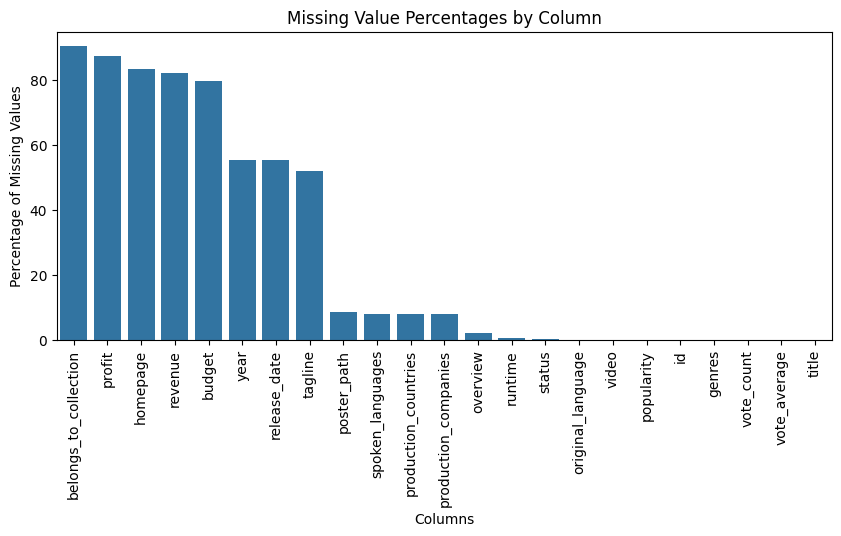

In [26]:
plt.figure(figsize=(10,4))
sns.barplot(x = nulos.index, y = nulos.values)
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Value Percentages by Column')
plt.show()

In [27]:
# Ajustar la precisión de visualización a 2 decimales
# pd.set_option('display.float_format', '{:.2f}'.format)

missing_percentage = movies.isnull().mean() * 100

# Convertir a DataFrame
missing_percentage = missing_percentage.reset_index()
missing_percentage.columns = ['Column', 'Nulos']

missing_percentage

Column      Nulos
0                   title   0.000000
1                overview   2.044642
2            release_date  55.296887
3            vote_average   0.002180
4              vote_count   0.002180
5                  genres   0.002180
6                      id   0.002180
7       original_language   0.026157
8              popularity   0.002180
9                  budget  79.592815
10                revenue  82.156247
11                runtime   0.547127
12                 status   0.159125
13                tagline  51.959630
14                  video   0.004360
15  belongs_to_collection  90.306478
16               homepage  83.252681
17            poster_path   8.640684
18   production_companies   7.849420
19   production_countries   7.849420
20       spoken_languages   7.849420
21                 profit  87.195919
22                   year  55.296887

Se eliminan todas las peliculas que no puedan ser identificadas por un id:

In [28]:
movies[(movies['id'].isna())]

title                                           overview  \
23249  Munthiri Kaadu  In a Village Where they used to Honor Kill Lov...   

      release_date  vote_average vote_count genres   id original_language  \
23249          NaT           NaN        NaN    NaN  NaN               NaN   

      popularity  budget  ...  tagline video belongs_to_collection homepage  \
23249        NaN     NaN  ...      NaN   NaN                   NaN      NaN   

      poster_path production_companies production_countries spoken_languages  \
23249         NaN                  NaN                  NaN              NaN   

      profit year  
23249    NaN  NaN  

[1 rows x 23 columns]

In [29]:
# Elimino pelicula con id na o nulo
movies = movies[(movies['id'].notna()) & (movies['id'] != 'ta') & (movies['id'] != '20/08/1997') & (movies['id'] != '29/09/2012') & (movies['id'] != '01/01/2014')]

In [30]:
# Convierte el id a entero
movies['id'] = movies['id'].astype('int')

# Exploratory Data Analysis (EDA)

#### Worldclouds: 
Estudiar la importancia de la presencia de ciertas palabras en los titulos y descripcion de la pelicula.

In [31]:
movies['title'] = movies['title'].astype('str')
words_title = ' '.join(movies['title'])

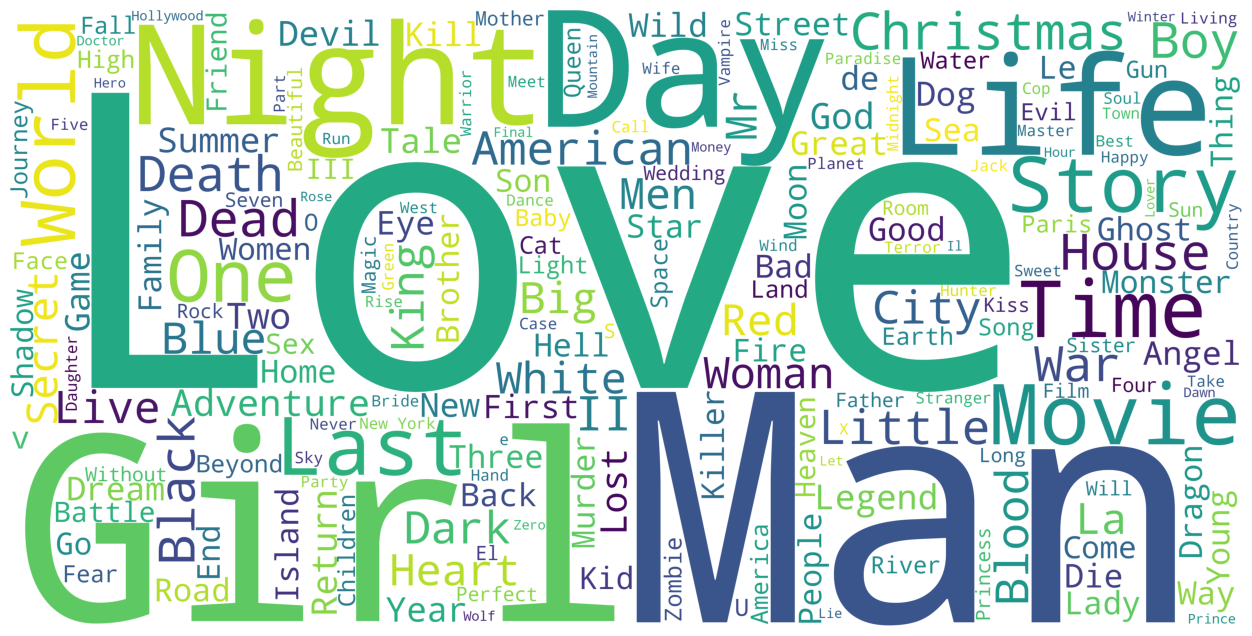

In [32]:
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(words_title)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

La palabra **Love** es la mas comun dentro de la eleccion de palabras para titulos. **Man**, **Day** y **Girl** tambien son palabras comunmente utilizadas. Esto encapsula bastante bien la idea de la presencia del romance en las películas.

In [33]:
movies['overview'] = movies['overview'].astype('str')
words_overview = ' '.join(movies['overview'])

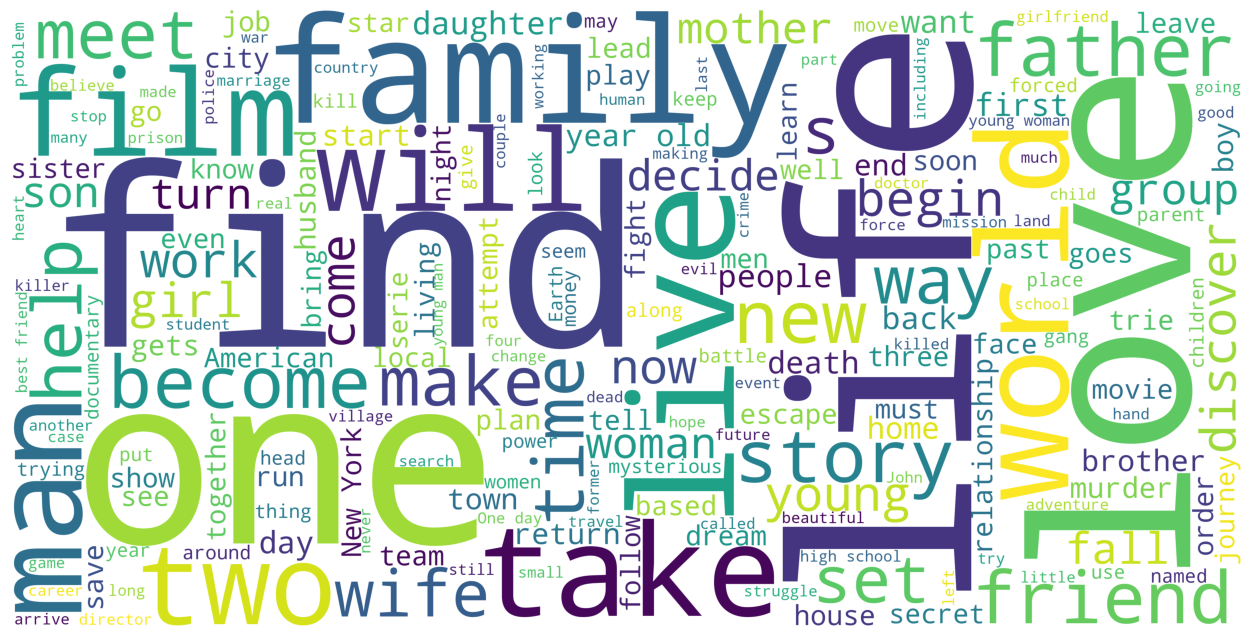

In [34]:
overview_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(words_overview)
plt.figure(figsize=(16,8))
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.show()

**Find**, **Life** y **One** son las palabras mas frecuentes dentro de las descripciones de las peliculas. **Love**, **Man** y **Girl** no solo estan presentes en los titulos, sino que se repiten en la descripcion.

#### Lenguaje y Paises:
Estudiar la procedencia de las peliculas.

In [35]:
movies['production_countries'] = movies['production_countries'].fillna('[]').apply(ast.literal_eval)
movies['production_countries'] = movies['production_countries'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [36]:
country = movies.apply(lambda x: pd.Series(x['production_countries']),axis=1).stack().reset_index(level=1, drop=True)
country.name = 'countries'

In [37]:
countries = movies.drop('production_countries', axis=1).join(country)
countries = pd.DataFrame(countries['countries'].value_counts())
countries['country'] = countries.index
countries.columns = ['count', 'country']
countries = countries.reset_index(drop=True)

countries.head(10)

count                   country
0  19770  United States of America
1   3743            United Kingdom
2   3610                    France
3   2082                   Germany
4   2013                     Italy
5   1659                    Canada
6   1564                     Japan
7    897                     Spain
8    815                    Russia
9    792                     India

La mayoria de las peliculas fueron producidas en **Estados Unidos** dado que la mayoria de las peliculas que comprenden el dataset son en ingles.

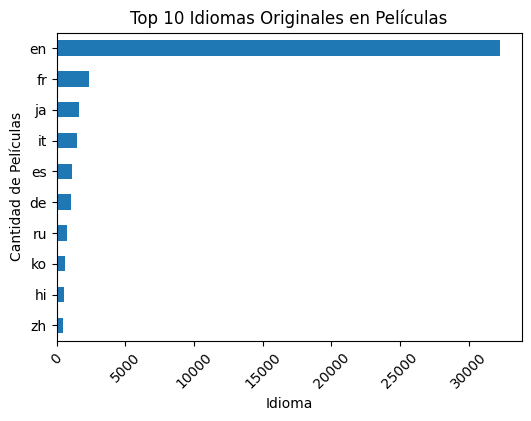

In [38]:
top_languages = movies['original_language'].value_counts().head(10)

# Invertir el orden para que el gráfico sea descendente
top_languages = top_languages.sort_values()

# Creando el gráfico de barras
plt.figure(figsize=(6, 4))
top_languages.plot(kind='barh')
plt.title('Top 10 Idiomas Originales en Películas')
plt.xlabel('Idioma')
plt.ylabel('Cantidad de Películas')
plt.xticks(rotation=45)
plt.show()

In [39]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_63925/3926210268.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [40]:
merged = world.set_index('name').join(countries.set_index('country'))

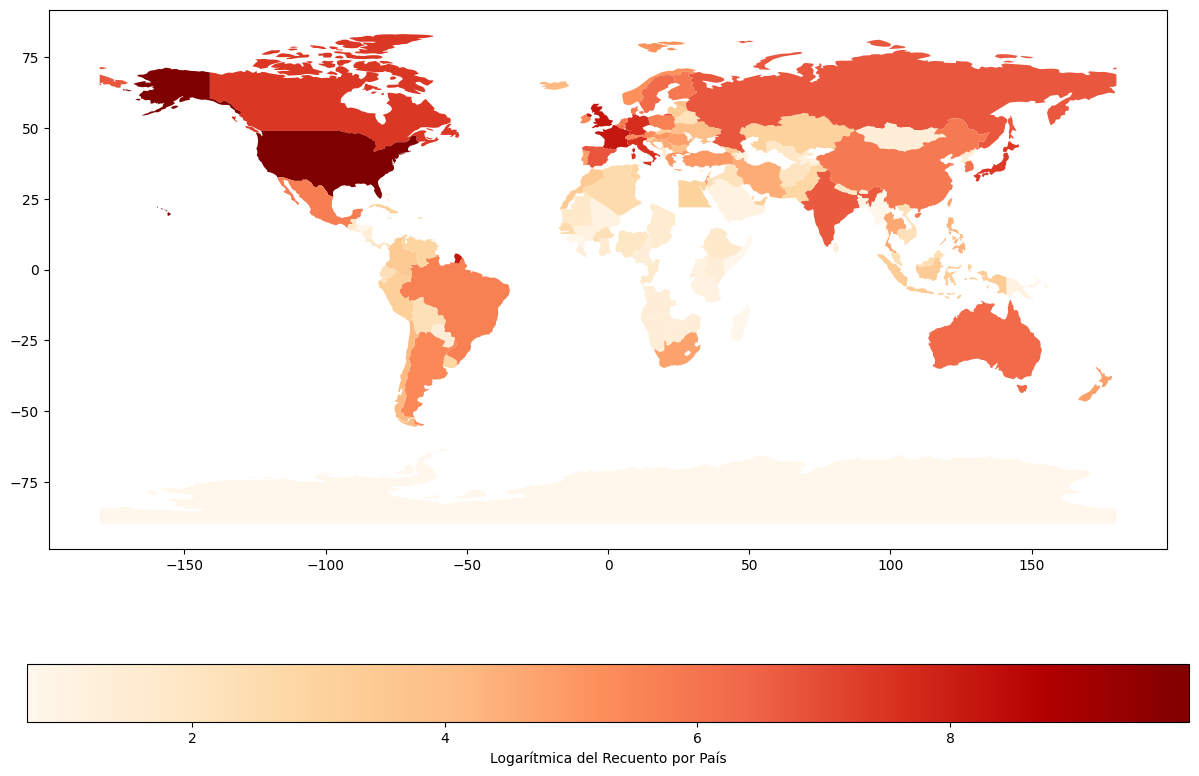

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Reemplazar valores de 'count' igual a 0 con un número muy pequeño para evitar problemas con el logaritmo
merged['count_log'] = np.log(merged['count'] + 1)

merged.plot(column='count_log', ax=ax, cmap='OrRd', legend=True,
            norm=plt.Normalize(vmin=merged['count_log'].min(), vmax=merged['count_log'].max()),
            legend_kwds={'label': "Logarítmica del Recuento por País",
                         'orientation': "horizontal"})
plt.show()

Se toma el logaritmo de la cantidad en el grafico para poder representar la informacion mejor dado el desbalance presentado por la presencia mayoritaria de peliculas estadounidenses. Ademas de **Estados Unidos**, **Europa** es un gran productor de peliculas.

#### Sagas:

In [42]:
movies['belongs_to_collection'] = movies['belongs_to_collection'].apply(extract_name)

In [43]:
# Almaceno los registros si las compañias productoras es una lista no vacía
saga = movies[movies['belongs_to_collection'].notna()]

In [44]:
saga = saga.pivot_table(index='belongs_to_collection', values='revenue', aggfunc={'revenue': ['mean', 'sum', 'count']}).reset_index()

In [45]:
# Suponiendo que tu DataFrame se llama df
# Ajusta el formato de los números flotantes para que no usen notación científica
pd.set_option('display.float_format', '{:.0f}'.format)

In [46]:
saga.sort_values('sum', ascending=False).head(10)

belongs_to_collection  count      mean        sum
534               Harry Potter Collection      8 963420928 7707367425
1118                 Star Wars Collection      8 929311849 7434494790
626                 James Bond Collection     25 282609021 7065225521
1268  The Fast and the Furious Collection      8 640637349 5125098793
934   Pirates of the Caribbean Collection      5 904315365 4521576826
1500              Transformers Collection      5 873220249 4366101244
312              Despicable Me Collection      4 922767554 3691070216
1441              The Twilight Collection      5 668421458 3342107290
591                    Ice Age Collection      5 643341711 3216708553
646              Jurassic Park Collection      4 757871036 3031484143

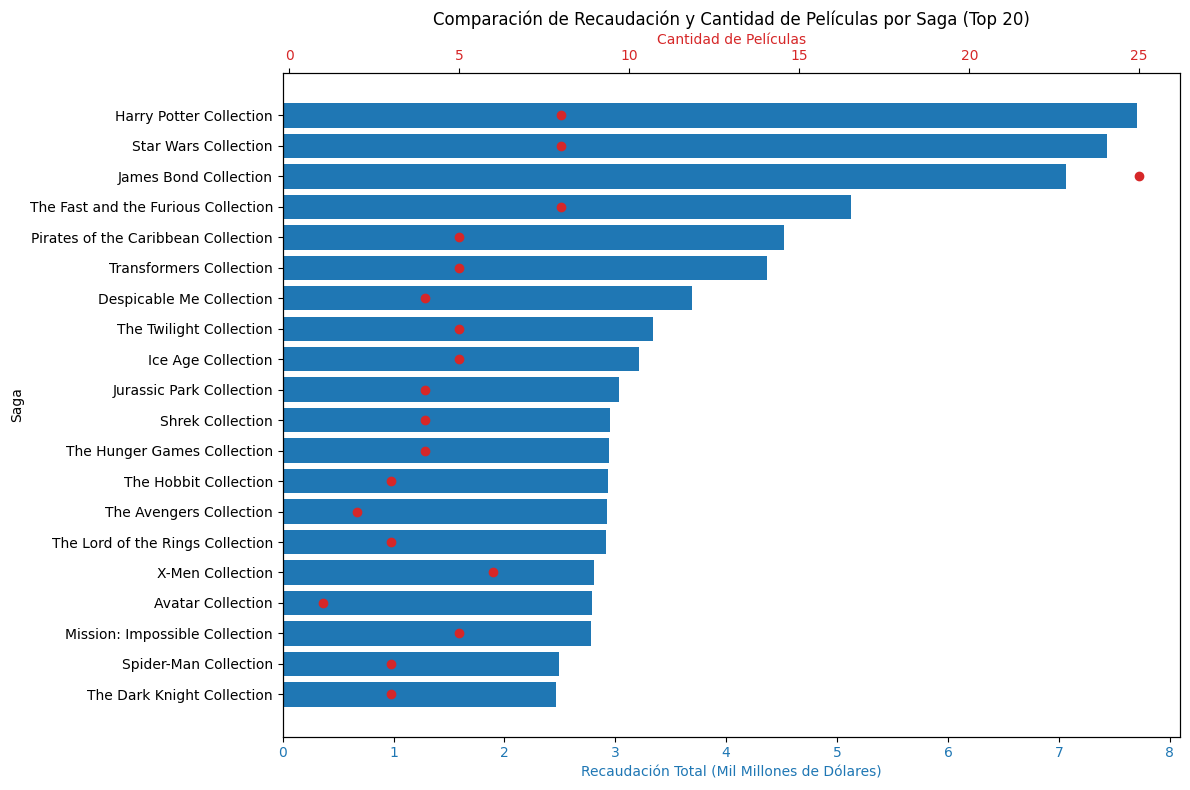

In [47]:
# Tomar las 20 franquicias principales
top_sagas = saga.sort_values(by='sum', ascending=False).head(20)
top_sagas = top_sagas.sort_values(by='sum', ascending=True)

# Configurando el gráfico
fig, ax1 = plt.subplots(figsize=(12, 8))

# Eje para la cantidad recaudada
color = 'tab:blue'
ax1.set_xlabel('Recaudación Total (Mil Millones de Dólares)', color=color)
ax1.set_ylabel('Saga')
ax1.barh(top_sagas['belongs_to_collection'], top_sagas['sum'] / 1e9, color=color)
ax1.tick_params(axis='x', labelcolor=color)

# Crear un segundo eje para la cantidad de películas
ax2 = ax1.twiny()  # Instancia un segundo eje que comparte el mismo eje y
color = 'tab:red'
ax2.set_xlabel('Cantidad de Películas', color=color)
ax2.plot(top_sagas['count'], top_sagas['belongs_to_collection'], color=color, marker='o', linestyle='None')
ax2.tick_params(axis='x', labelcolor=color)

# Título y ajustes finales
plt.title('Comparación de Recaudación y Cantidad de Películas por Saga (Top 20)')
fig.tight_layout()  # Para asegurar que no haya solapamiento de etiquetas
plt.show()

La saga de **Harry Potter** es la más exitosa en la industria cinematográfica, recaudando más de 7.707 mil millones de dólares con 8 películas. Las películas de **Star Wars** ocupan un cercano segundo lugar, con 7.403 mil millones de dólares también de 8 películas. **James Bond** está en tercer lugar, pero la saga tiene significativamente más películas en comparación con las demás en la lista y, por lo tanto, un promedio de recaudación mucho menor.

Segun la ganancia media de las sagas:

In [48]:
saga.sort_values('mean', ascending=False).head(10)

belongs_to_collection  count       mean        sum
109                     Avatar Collection      1 2787965087 2787965087
1198              The Avengers Collection      2 1462480802 2924961604
465                     Frozen Collection      1 1274219009 1274219009
432               Finding Nemo Collection      2  984453212 1968906425
1303                The Hobbit Collection      3  978507785 2935523356
1339     The Lord of the Rings Collection      3  972181581 2916544743
534               Harry Potter Collection      8  963420928 7707367425
1118                 Star Wars Collection      8  929311849 7434494790
312              Despicable Me Collection      4  922767554 3691070216
934   Pirates of the Caribbean Collection      5  904315365 4521576826

La **Saga Avatar**, aunque actualmente solo consta de una película, es la franquicia más exitosa de todos los tiempos, con esa única película recaudando cerca de 3 mil millones de dólares. La **Saga de Harry Potter** sigue siendo la más exitosa con al menos 5 películas.

#### Companias Productoras:

In [49]:
movies['production_companies'] = movies['production_companies'].apply(extract_name)

In [50]:
# Almaceno los registros si las compañias productoras es una lista no vacía
companies = movies[movies['production_companies'].notna()]

In [51]:
companies = companies.pivot_table(index='production_companies', values='revenue', aggfunc={'revenue': ['sum', 'mean', 'count']}).reset_index()

In [52]:
companies.sort_values('sum', ascending=False).head(10)

production_companies  count      mean         sum
6773                      Paramount Pictures    364 124316378 45251161524
9335                      Universal Pictures    379 116558171 44175546804
9596                    Walt Disney Pictures    138 262991957 36292890050
2073                       Columbia Pictures    221 138471202 30602135588
9201  Twentieth Century Fox Film Corporation    269 108766839 29258279795
6305                         New Line Cinema    180  86878802 15638184400
9488               Village Roadshow Pictures     73 167963771 12261355291
9615                            Warner Bros.    158  77327976 12217820211
2650                          DreamWorks SKG     62 179908795 11154345261
5403                               Lucasfilm     22 449928232  9898421106

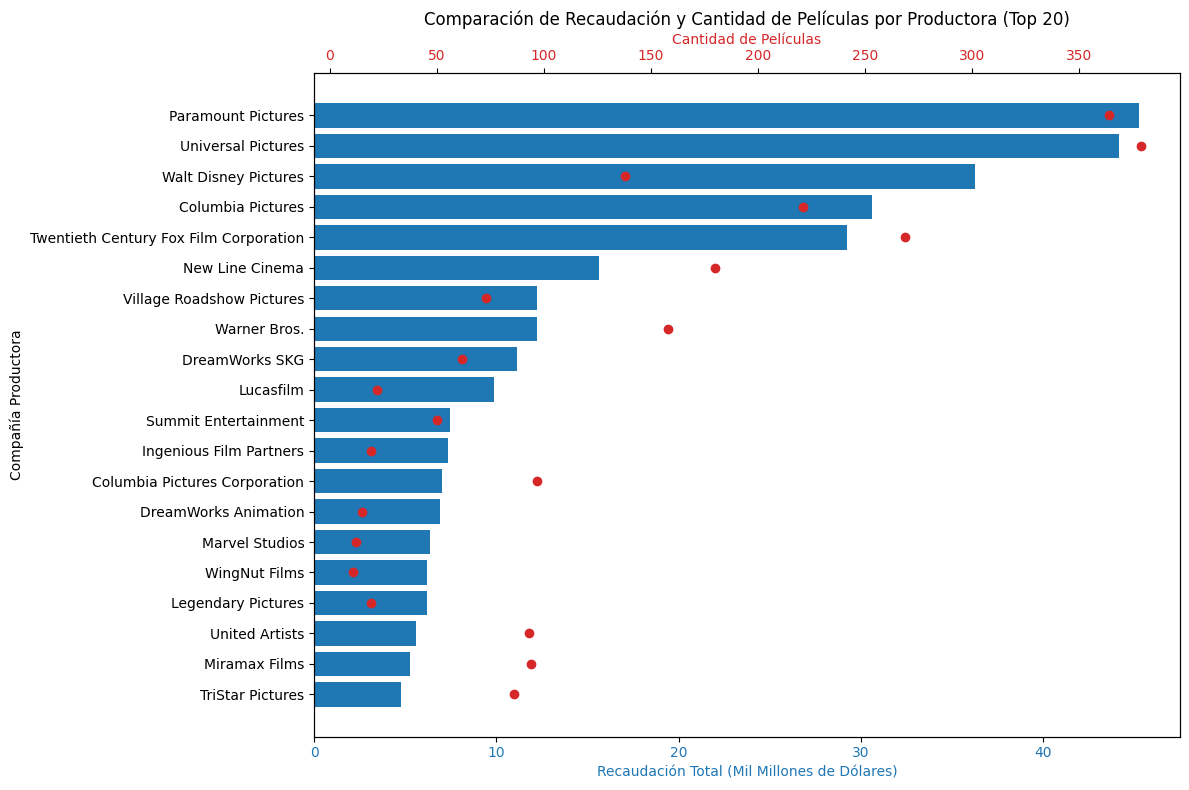

In [53]:
# Tomar las 20 franquicias principales
top_companies = companies.sort_values(by='sum', ascending=False).head(20)
top_companies = top_companies.sort_values(by='sum', ascending=True)

# Configurando el gráfico
fig, ax1 = plt.subplots(figsize=(12, 8))

# Eje para la cantidad recaudada
color = 'tab:blue'
ax1.set_xlabel('Recaudación Total (Mil Millones de Dólares)', color=color)
ax1.set_ylabel('Compañía Productora')
ax1.barh(top_companies['production_companies'], top_companies['sum'] / 1e9, color=color)
ax1.tick_params(axis='x', labelcolor=color)

# Crear un segundo eje para la cantidad de películas
ax2 = ax1.twiny()  # Instancia un segundo eje que comparte el mismo eje y
color = 'tab:red'
ax2.set_xlabel('Cantidad de Películas', color=color)
ax2.plot(top_companies['count'], top_companies['production_companies'], color=color, marker='o', linestyle='None')
ax2.tick_params(axis='x', labelcolor=color)

# Título y ajustes finales
plt.title('Comparación de Recaudación y Cantidad de Películas por Productora (Top 20)')
fig.tight_layout()  # Para asegurar que no haya solapamiento de etiquetas
plt.show()

**Paramount Pictures** y **Universal Pictures** se destacan como las productoras con el mayor número de películas, aunque no necesariamente es la que lidera en términos de recaudación por pelicula, lo que sugiere una estrategia de producción más enfocada en cantidad. Por otro lado, algunas productoras como **Walt Disney Pictures** y **Pixar Animation Studios**, presentan una menor cantidad de producciones pero con una recaudación total muy alta, indicando que sus películas tienden a ser éxitos que generan ingresos significativos.

#### Popularidad, Voto Promedio y Cantidad de Votos:
En esta sección, trabajaremos con las métricas proporcionadas por los usuarios de TMDB. Intentaremos obtener una comprensión más profunda de las características de popularidad, promedio de votos y conteo de votos e intentaremos deducir cualquier relación entre ellas, así como con otras características numéricas como el presupuesto y los ingresos.

In [54]:
# Convertir las columnas popularity, vote_count y vote_average a numéricas
movies['popularity'] = pd.to_numeric(movies['popularity'], errors='coerce')
movies['vote_count'] = pd.to_numeric(movies['vote_count'], errors='coerce')
movies['vote_average'] = pd.to_numeric(movies['vote_average'], errors='coerce')

In [55]:
movies.describe()

release_date  vote_average  vote_count      id  \
count                          20508         45874       45874   45874   
mean   1994-04-10 18:10:15.096547712             6         166  149806   
min              1900-01-01 00:00:00             0           0       2   
25%              1981-01-04 18:00:00             5           3   28300   
50%              2002-10-09 00:00:00             6          11   68726   
75%              2011-10-17 00:00:00             7          47  207694   
max              2027-06-05 00:00:00            10       27972 1203973   
std                              NaN             2         742  197335   

       popularity    budget    revenue     profit  year  
count       45874      9362       8185       5874 20508  
mean            6  23944647   74158221   64651372  1994  
min             0         1          1 -185600000  1900  
25%             0   2200000    2543216   -1871871  1981  
50%             1  10000000   17322136   11689234  2002  
75%             5  28000000   69633110   66205999  2011  
max          2719 460000000 2800000000 2550965087  2027  
std            30  38414701  163594159  157606049    23

<Axes: ylabel='Frequency'>

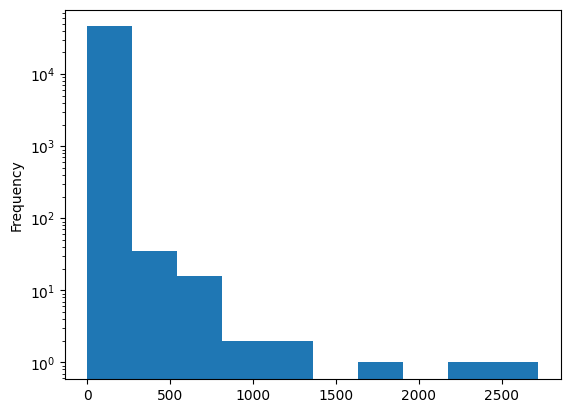

In [56]:
# Boxplot de la popularidad
# sns.distplot(movies['popularity'])
movies['popularity'].plot(logy=True, kind='hist')

La popularidad parece seguir una distribucion Lognormal, por lo que son muchos con baja popularidad y pocos que consiguen llegar a un valor alto. La media es 2.9, pero el maximo llega a 2719. De todas formas, como se ve en el grafico, todas las peliculas bajo el percentil 75 tienen un valor menor a 9.

La popularidad de las peliculas se mide segun (https://developer.themoviedb.org/docs/popularity-and-trending): 
- Number of votes for the day
- Number of views for the day
- Number of users who marked it as a "favourite" for the day
- Number of users who added it to their "watchlist" for the day
- Release date
- Number of total votes
- Previous days score

In [57]:
movies[['title', 'popularity', 'year']].sort_values('popularity', ascending=False).head(10)

title  popularity  year
25271                                        Oppenheimer        2719   NaN
34623                                        The Creator        2234   NaN
12617                            Five Nights at Freddy's        1859   NaN
11791                                        Expend4bles        1294   NaN
22602      Mission: Impossible - Dead Reckoning Part One        1145  2023
12125                                             Fast X         973   NaN
35301                                    The Equalizer 3         847   NaN
36613  The Hunger Games: The Ballad of Songbirds & Sn...         800   NaN
29129                                              Saw X         755   NaN
37923                                        The Marvels         713  2023

In [58]:
# Pelicula mas popular por año
popular_year = movies.sort_values('popularity', ascending=False).groupby('year').first().reset_index()

In [59]:
# Crea un gráfico de barras interactivo con Plotly Express
fig = px.bar(
    popular_year,
    x='popularity',
    y='title',
    orientation='h',  # Gráfico de barras horizontal
    color='year',  # Colorea por año
    title='Película más popular por año'
)

# Configura los ejes y el título del gráfico
fig.update_layout(
    xaxis_title='Popularidad',
    yaxis_title='Título de la película',
    yaxis=dict(
        categoryorder='array',
        categoryarray=popular_year.sort_values('year', ascending=False)['year'].unique()
    ),
    coloraxis_showscale=False  # Oculta la barra de color si no la necesitas
)

# Muestra el gráfico
fig.show()

<Axes: xlabel='vote_average'>

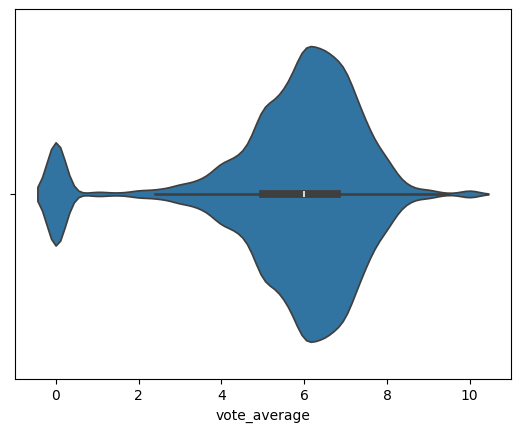

In [60]:
sns.violinplot(x=movies['vote_average'])

Parece que los votantes son bastante estrictos con sus notas, la media de los votos es de 6 de 10. Hay una gran elevacion en la distribucion en la puntuacion minima, pero esto puede ser producto de peliculas que no tuvieron evaluacion por votantes.

Para un analisis mas certero se tendran en cuenta unicamente los valores de votacion con mas de 5000 votos. Este criterio es empleado por IMDB's para seleccionar el top 250 peliculas.

<Axes: xlabel='vote_average'>

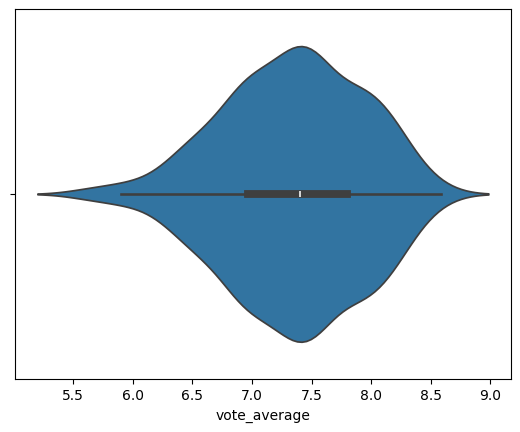

In [61]:
sns.violinplot(x=movies.loc[movies['vote_count'] > 5000,'vote_average'])

En este caso, se puede ver que la distribucion de los votos promedio varia entre 4 y 10. Por lo que los votantes son mas propensos a criticar positivamente las peliculas.

In [62]:
movies[movies['vote_count'] > 5000][['title', 'vote_average', 'vote_count' ,'year']].sort_values('vote_average', ascending=False).head(10)

title  vote_average  vote_count  year
35980              The Godfather Part II             9       11453   NaN
39746           The Shawshank Redemption             8        8358   NaN
35979                      The Godfather             8        6024   NaN
31188  Spider-Man: Into the Spider-Verse             8       14237  2018
21145            L√©on: The Professional             8       13810   NaN
12360                         Fight Club             8        9678   NaN
27129                       Pulp Fiction             8        8670  1994
34758                    The Dark Knight             8       12269   NaN
12610                    Five Feet Apart             8        5294   NaN
27206       Puss in Boots: The Last Wish             8        6627  2022

**The Godfather** y **The Shawshank Redemption** son las dos películas más aclamadas por la crítica en la base de datos de TMDB. Tienen una calificación de  9 en TMDB.

#### Generos:
Distribucion de genero y exploracion de tendencias.

In [63]:
movies['genres'] = get_names(movies['genres'])

In [64]:
movies['genres'].head()

0                            [Documentary]
1                          [Comedy, Drama]
2    [Horror, Action, Adventure, Thriller]
3       [Drama, Mystery, Horror, Thriller]
4                            [Documentary]
Name: genres, dtype: object

In [65]:
s = movies.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
genres = movies.drop('genres', axis=1).join(s)

In [66]:
genres_count = genres['genre'].value_counts()
genres_count = genres_count.reset_index()
genres_count.columns = ['Genre', 'Count']

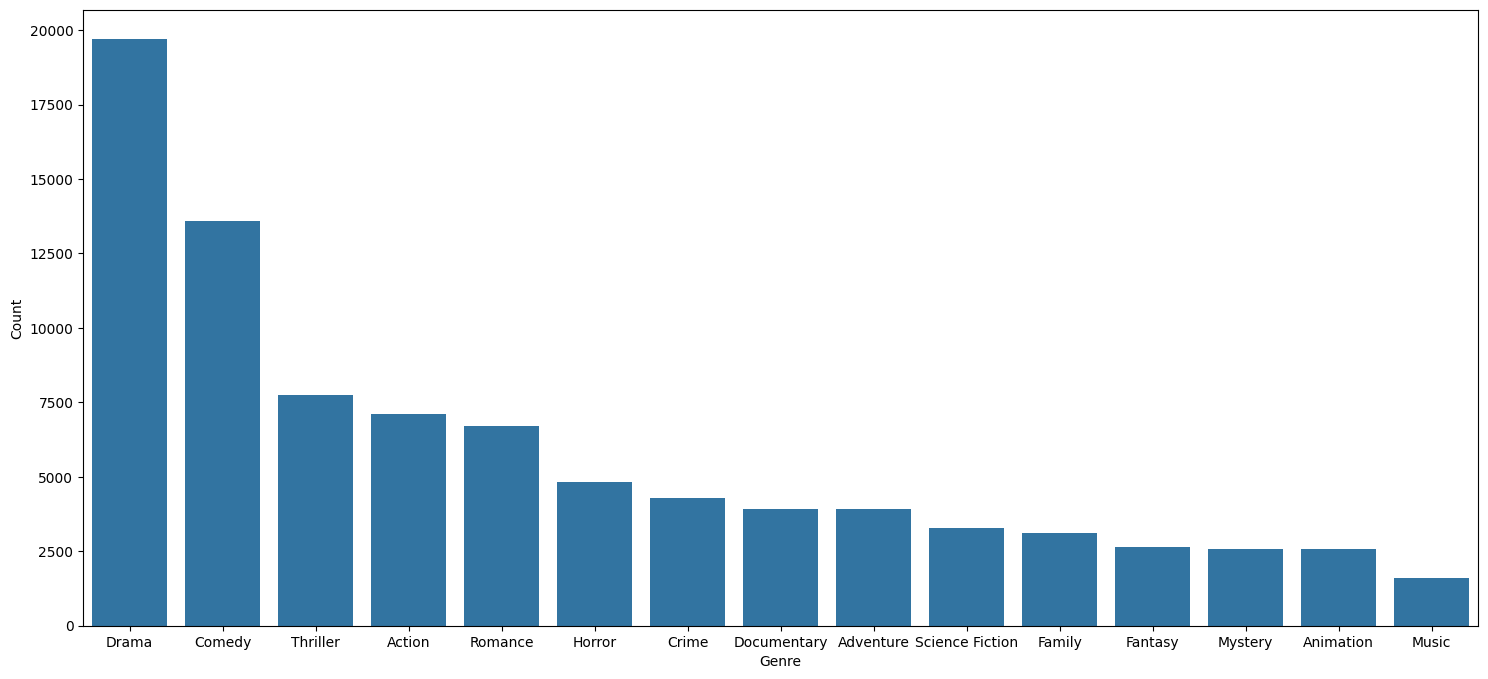

In [67]:
plt.figure(figsize=(18,8))
sns.barplot(x='Genre', y='Count', data=genres_count.head(15))
plt.show()

El **drama** es el género más común, con casi la mitad de las películas. La **comedia** llega en un distante segundo lugar, con un 25% de las películas. Otros géneros principales representados en el top 10 son **Acción, Terror, Crimen, Misterio, Ciencia Ficción, Animación y Fantasía**.

Para evaluar tendencias solo estaremos observando tendencias a partir del año 2000. Consideraremos solo aquellos temas que aparezcan en los 10 géneros más populares. 

In [79]:
tendencia_genres = genres[(genres['genre'].isin(genres_count['Genre'].head(10))) & (genres['year'] >= 2000) & (genres['year'] <= 2023)]

In [80]:
ctab = pd.crosstab(tendencia_genres['year'], tendencia_genres['genre'])
ctab = ctab.div(ctab.sum(axis=1), axis=0)

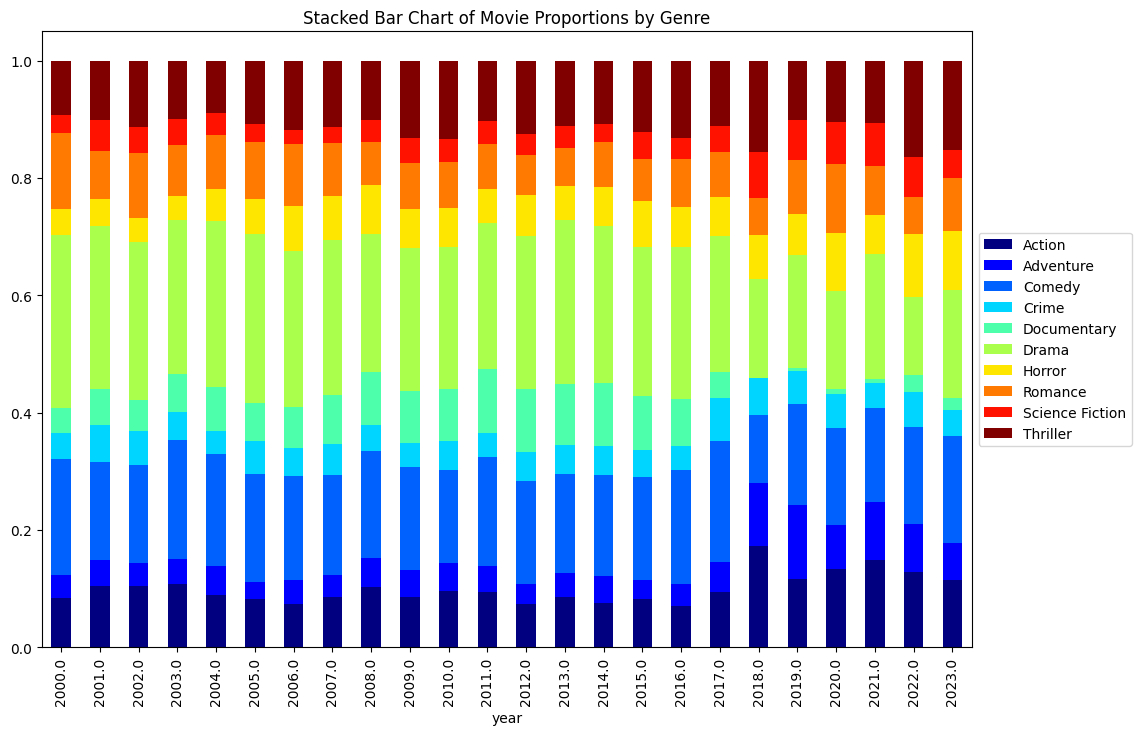

In [81]:
ctab.plot(kind='bar', stacked=True, colormap='jet', figsize=(12,8))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Stacked Bar Chart of Movie Proportions by Genre")
plt.show()

La proporción de películas de cada género se ha mantenido bastante constante desde principios de este siglo, las mayores diferenciaciones se encuentran a partir del 2017. La proporción de películas **dramáticas** y **comedias** han caído. Las películas de **Thriller** y **Horror** han aumentado ligeramente.

<Figure size 800x2000 with 0 Axes>

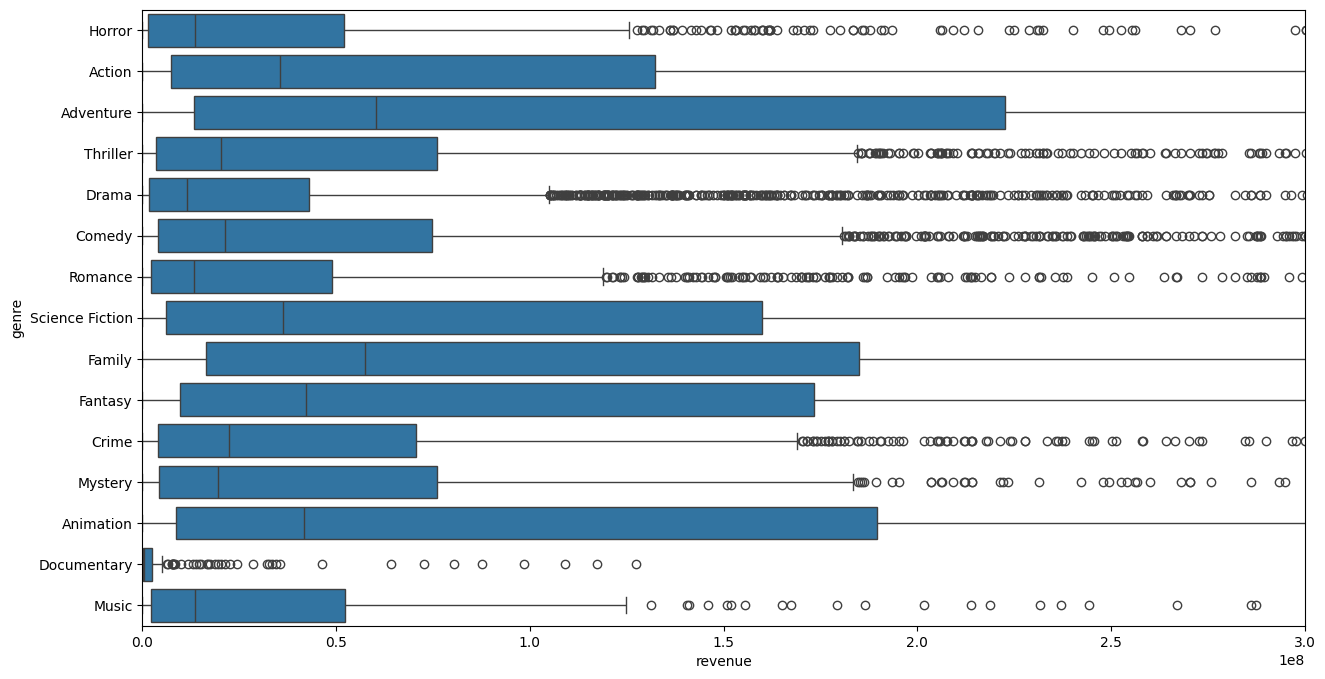

In [88]:
tendencia_genres = genres[(genres['genre'].isin(genres_count['Genre'].head(15)))]
tendencia_genres = tendencia_genres.dropna(subset=['revenue'])
tendencia_genres = tendencia_genres.drop_duplicates(subset=['title', 'genre'])


plt.figure(figsize=(8, 20))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
sns.boxplot(y='genre', x='revenue', data=tendencia_genres, ax=ax)
ax.set_xlim([0, 3e8])
plt.show()

Las películas de **Aventura**, **Animación** y **Familia** tienen el rango intercuartíl más amplio, así como la mediana de ingresos más alta entre todos los géneros representados. **Fantasía**, **Ciencia Ficción** tienen ingresos medianos similares aunque no son tan frecuentes como se analizo anteriormente.

#### Cast y Crew

In [89]:
credits_df = pd.read_csv('input/credits.csv')
credits_df.head()

id                                               cast  \
0  299054  [{'cast_id': 976, 'name': 'Jason Statham', 'ch...   
1  609681  [{'cast_id': 60073, 'name': 'Brie Larson', 'ch...   
2  670292  [{'cast_id': 1117313, 'name': 'John David Wash...   
3  385687  [{'cast_id': 12835, 'name': 'Vin Diesel', 'cha...   
4  951491  [{'cast_id': 2144, 'name': 'Tobin Bell', 'char...   

                                                crew  
0  [{'crew_id': 966, 'name': 'Tim Maurice-Jones',...  
1  [{'crew_id': 7232, 'name': 'Sarah Halley Finn'...  
2  [{'crew_id': 947, 'name': 'Hans Zimmer', 'depa...  
3  [{'crew_id': 1302, 'name': 'Susie Figgis', 'de...  
4  [{'crew_id': 2127, 'name': 'James Wan', 'depar...

In [90]:
# Merge movies and credits DataFrames
movies = movies.merge(credits_df, on='id', how='left').drop_duplicates(subset='id', keep='first')

In [91]:
movies['director'] = get_director(movies['crew'])

In [92]:
movies['cast'] = get_names(movies['cast'])
movies['crew'] = get_names(movies['crew'])

In [93]:
movies['cast_size'] = movies['cast'].apply(lambda x: len(x))
movies['crew_size'] = movies['crew'].apply(lambda x: len(x))

In [94]:
s = movies.apply(lambda x: pd.Series(x['cast']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'actor'
actors = movies.drop('cast', axis=1).join(s)

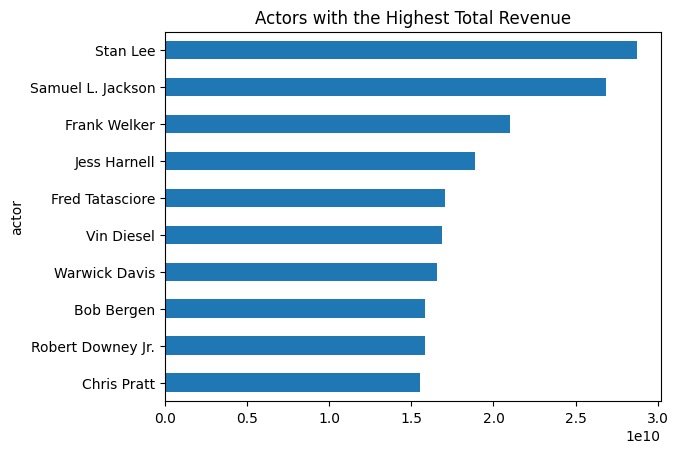

In [95]:
plt.title('Actors with the Highest Total Revenue')
actors.groupby('actor')['revenue'].sum().sort_values(ascending=False).head(10).sort_values().plot(kind='barh')
plt.show()

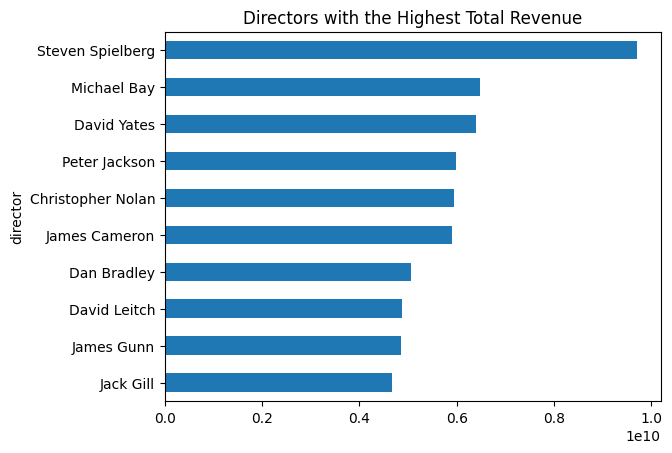

In [96]:
plt.title('Directors with the Highest Total Revenue')
movies.groupby('director')['revenue'].sum().sort_values(ascending=False).head(10).sort_values().plot(kind='barh')
plt.show()

Se almacena el dataset final con todos los cambios para poder optimizar la rápida utlización en corridas posteriores

In [97]:
print("Cantidad final de observaciones en el dataset: {}".format(movies.shape[0]))
movies['runtime'] = pd.to_numeric(movies['runtime'], errors='coerce')
movies.to_parquet('movies_final.parquet')

Cantidad final de observaciones en el dataset: 45620


# Sistema de Recomendación

### Content Based Recommender:

Utiliza características de las películas como género, director, actores, descripción, y calificaciones.

Por ejemplo, si a un usuario le gustan las películas de ciencia ficción, el sistema recomendaría otras películas de ciencia ficción con actores o directores similares.

#### En base al overview:

In [99]:
movies['overview'].head()

0    Through intimate interviews, provocative art, ...
1    A pair of horny college guys get summer jobs a...
2    As a grisly virus rampages a city, a lone man ...
3    Inspired by actual events, a group of 12 year ...
4    From her childhood bedroom in the Chicago subu...
Name: overview, dtype: object

In [100]:
# Convierto todos los nulos a un mismo valor para poder trabajar con ellos
movies.replace([None, "nan", "", "NA", "NULL", -9999], np.nan, inplace=True)

In [101]:
print('Proporcion de Nulos: ', round(movies['overview'].isna().sum() * 100 / len(movies),2),'%')

Proporcion de Nulos:  2.05 %


In [102]:
df = movies[movies['overview'].notna()]

No se tendra en cuenta las peliculas sin descripcion.

Se utiliza TF-IDF para transformar la descripcion. Esta tecnica nos dira **que tan relevante es una palabra en el overview, para la colección de peliculas**.

In [103]:
tfidf = TfidfVectorizer(stop_words='english')

tags_matrix = tfidf.fit_transform(df['overview'])

tags_matrix.shape

(44684, 75728)

Aproximadamente 76000 palabras fueron utilizadas para describir las 45000 peliculas.

In [104]:
# Obtener nombres de características (palabras)
feature_names = tfidf.get_feature_names_out()

# Sumar las frecuencias TF-IDF de cada palabra
sums = tags_matrix.sum(axis=0)

# Crear un DataFrame con palabras y sus frecuencias
data = []
for col, sum in zip(feature_names, sums.A1):
    data.append((col, sum))

word_freq_df = pd.DataFrame(data, columns=['word', 'freq'])

# Ordenar por frecuencia
word_freq_df = word_freq_df.sort_values(by='freq', ascending=False)

# Mostrar las palabras más frecuentes
print(word_freq_df.head(10))

         word  freq
38434    life   587
73952   young   551
40420     man   501
45852     new   463
23327    film   448
22544  family   436
39267    love   432
73232   world   419
63553   story   408
73096   woman   394


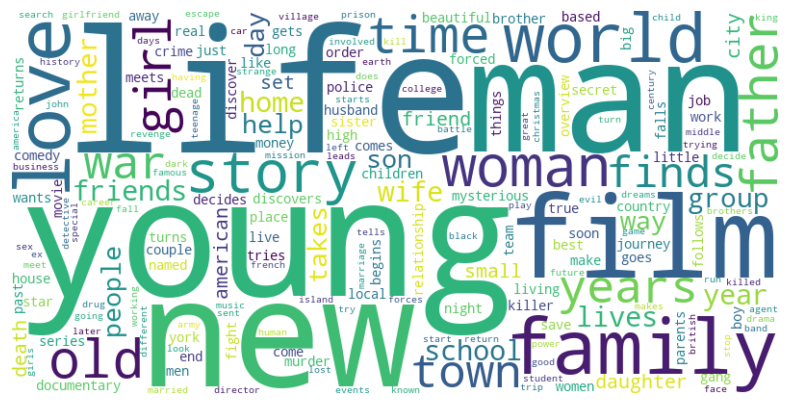

In [105]:
word_freq_dict = word_freq_df.set_index('word')['freq'].to_dict()

# Crear el word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

# Visualizar el word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Se calcula la **similitud coseno** entre las descripciones de las películas y se crea una matriz de similitud.

$$
\text{cosine\_similarity}(A, B) = \frac{A \cdot B}{\|A\| \cdot \|B\|}
$$


In [106]:
similarity_matrix = cosine_similarity(tags_matrix,tags_matrix)

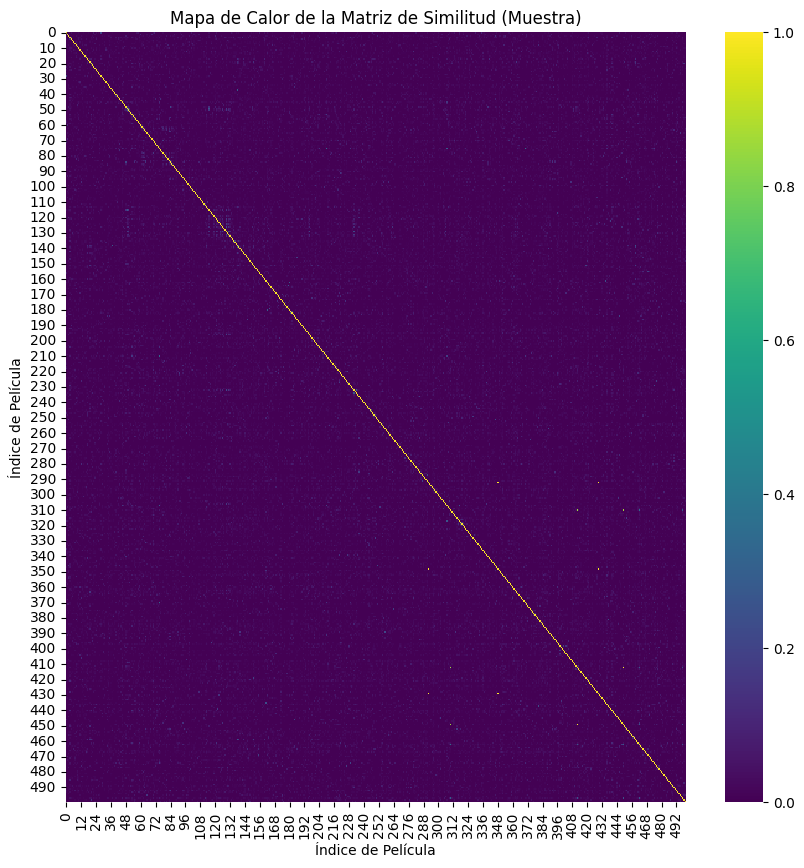

In [107]:
sampled_matrix = similarity_matrix[:500, :500]

# Crear el mapa de calor
plt.figure(figsize=(10, 10))
sns.heatmap(sampled_matrix, cmap='viridis')
plt.title('Mapa de Calor de la Matriz de Similitud (Muestra)')
plt.xlabel('Índice de Película')
plt.ylabel('Índice de Película')
plt.show()

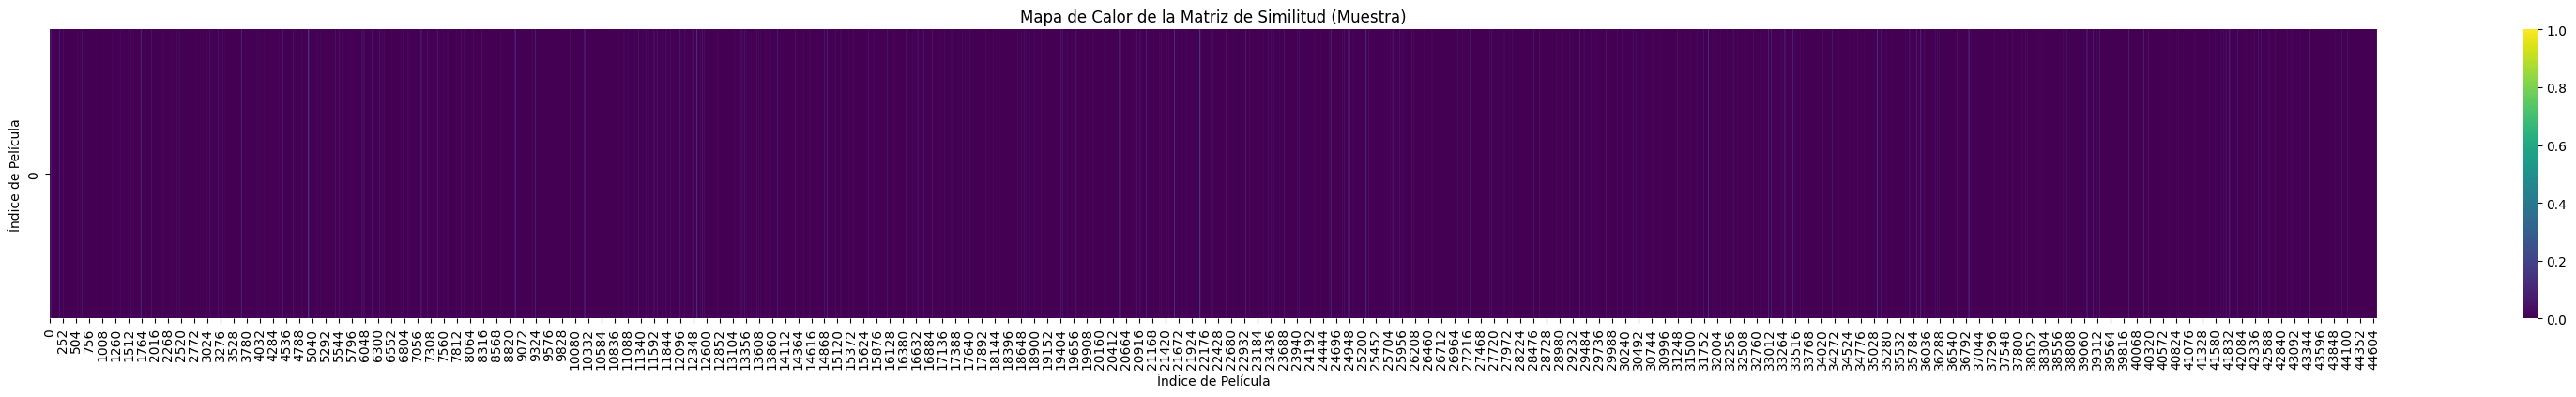

In [108]:
sampled_matrix = similarity_matrix[:1, :]

# Crear el mapa de calor
plt.figure(figsize=(40, 4))
sns.heatmap(sampled_matrix, cmap='viridis')
plt.title('Mapa de Calor de la Matriz de Similitud (Muestra)')
plt.xlabel('Índice de Película')
plt.ylabel('Índice de Película')
plt.show()

Se grafica una muestra para ver que tan representativo es el metodo para hacer una recomendacion. Pero como se puede ver, los valores de la similitud coseno tienden a ser cercanos a 0, por lo que las recomendaciones no seran del todo confiables.

In [109]:
movie = df.loc[0,'title']
print('Película: ', movie)

recomendacion = recommender(df, similarity_matrix, movie, 5)
print('Películas similares: ')
for index, row in recomendacion.iterrows():
    print(f"- {row['title']} (Score: {row['similarity_score']:.3f})")

Película:  !Women Art Revolution
Películas similares: 
- The Cool School (Score: 0.273)
- JLG/JLG: Self-Portrait in December (Score: 0.269)
- Museum Hours (Score: 0.246)
- Let Fury Have the Hour (Score: 0.244)
- The Object of Beauty (Score: 0.241)


In [110]:
movie = 'Despicable Me'
print('Película: ', movie)

recomendacion = recommender(df, similarity_matrix, movie, 5)
print('Películas similares: ')
for index, row in recomendacion.iterrows():
    print(f"- {row['title']} (Score: {row['similarity_score']:.3f})")

Película:  Despicable Me
Películas similares: 
- Saving Santa (Score: 0.227)
- The Happy Elf (Score: 0.193)
- Beethoven's Christmas Adventure (Score: 0.180)
- Elf (Score: 0.176)
- The Boss Baby: Christmas Bonus (Score: 0.173)


In [111]:
movie = "Harry Potter and the Philosopher's Stone"
print('Película: ', movie)

recomendacion = recommender(df, similarity_matrix, movie, 5)
print('Películas similares: ')
for index, row in recomendacion.iterrows():
    print(f"- {row['title']} (Score: {row['similarity_score']:.3f})")

Película:  Harry Potter and the Philosopher's Stone
Películas similares: 
- Joy Division (Score: 0.264)
- Heavy Metal in Baghdad (Score: 0.251)
- X: The Unheard Music (Score: 0.202)
- Metal: A Headbanger's Journey (Score: 0.191)
- The Decline of Western Civilization Part II: The Metal Years (Score: 0.187)


#### En base al cast, director, keywords y genero:

Se vincula la base con los keywords:

In [112]:
keywords_df = pd.read_csv('input/keywords.csv')
keywords_df.head()

Unnamed: 0      id                                           keywords
0        0.00  385687  [{'id': 9663, 'name': 'sequel'}, {'id': 9748, ...
1        1.00  299054  [{'id': 9663, 'name': 'sequel'}, {'id': 12551,...
2        2.00  951491  [{'id': 1547, 'name': 'mexico city, mexico'}, ...
3        3.00  926393  [{'id': 131, 'name': 'italy'}, {'id': 266013, ...
4        4.00  565770  [{'id': 2898, 'name': 'armor'}, {'id': 9715, '...

In [113]:
# Merge movies and credits DataFrames
movies = movies.merge(keywords_df, on='id', how='left').drop_duplicates(subset='id', keep='first')

In [114]:
movies['keywords'] = get_names(movies['keywords'])

Se selecciona unicamente los top 3 actores:

In [115]:
movies['cast'] = movies['cast'].apply(lambda x: x[:3] if len(x) >= 3 else x)

In [116]:
df = movies[['title', 'cast', 'director', 'keywords', 'genres']]

In [117]:
df = df.applymap(lambda x: np.nan if x == [] else x)

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_63925/2918052645.py:1: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [118]:
print('Proporcion de Nulos: ')
print( round(df.isna().sum() * 100 / len(movies),2))

Proporcion de Nulos: 
title       0.00
cast        5.15
director    2.00
keywords   30.30
genres      5.04
dtype: float64


In [119]:
df = df.dropna()

Se une toda la informacion para aplicar TF-IDF nuevamente. Se agrega multiples veces el nombre del director para darle mayor peso en la prediccion.

In [120]:
df['soup'] = df.apply(create_soup, axis=1)

In [121]:
tfidf = TfidfVectorizer(stop_words='english')

tags_matrix = tfidf.fit_transform(df['soup'])

tags_matrix.shape

(30492, 47237)

Aproximadamente 47237 palabras fueron utilizadas para describir las 30000 peliculas. Las palabras unicas disminuyeron.

In [122]:
# Obtener nombres de características (palabras)
feature_names = tfidf.get_feature_names_out()

# Sumar las frecuencias TF-IDF de cada palabra
sums = tags_matrix.sum(axis=0)

# Crear un DataFrame con palabras y sus frecuencias
data = []
for col, sum in zip(feature_names, sums.A1):
    data.append((col, sum))

word_freq_df = pd.DataFrame(data, columns=['word', 'freq'])

# Ordenar por frecuencia
word_freq_df = word_freq_df.sort_values(by='freq', ascending=False)

# Mostrar las palabras más frecuentes
print(word_freq_df.head(10))

            word   freq
11753      drama 723.65
8753      comedy 670.32
42161   thriller 448.18
35830    romance 428.02
361       action 425.76
19032     horror 359.98
21004       john 346.69
9486       crime 336.38
13613     family 309.21
510    adventure 285.19


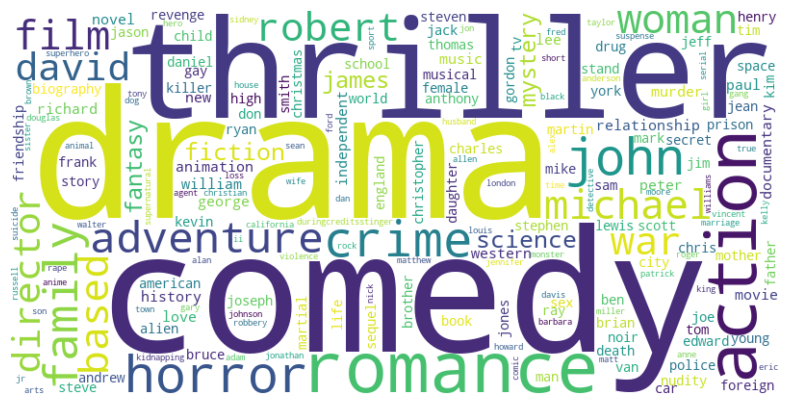

In [123]:
word_freq_dict = word_freq_df.set_index('word')['freq'].to_dict()

# Crear el word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

# Visualizar el word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Nuevamente se calcula la similitud coseno:

In [124]:
similarity_matrix = cosine_similarity(tags_matrix,tags_matrix)

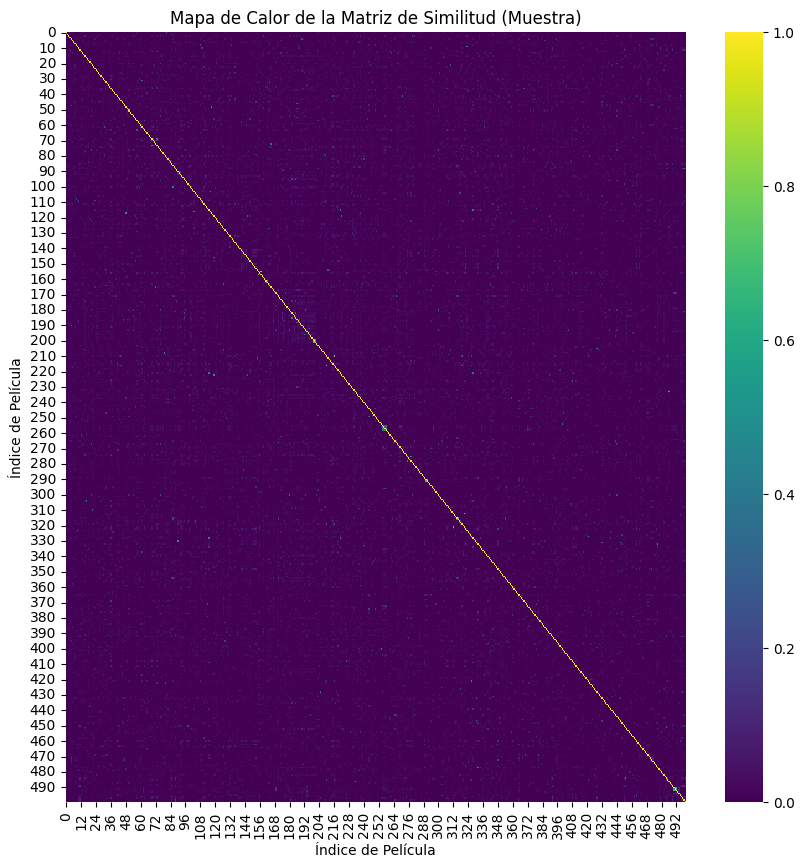

In [125]:
sampled_matrix = similarity_matrix[:500, :500]

# Crear el mapa de calor
plt.figure(figsize=(10, 10))
sns.heatmap(sampled_matrix, cmap='viridis')
plt.title('Mapa de Calor de la Matriz de Similitud (Muestra)')
plt.xlabel('Índice de Película')
plt.ylabel('Índice de Película')
plt.show()

Se grafico la matriz sobre la misma muestra y se pueden ver resultados un poco mas representativos que utilizando unicamente la descripcion de la pelicula.

In [126]:
movie = df.loc[0,'title']
print('Película: ', movie)

recomendacion = recommender(df, similarity_matrix, movie,5)
print('Películas similares: ')
for index, row in recomendacion.iterrows():
    print(f"- {row['title']} (Score: {row['similarity_score']:.3f})")

Película:  !Women Art Revolution
Películas similares: 
- Teknolust (Score: 0.849)
- Conceiving Ada (Score: 0.814)
- Trial and Error (Score: 0.213)
- Humpday (Score: 0.204)
- Changing Habits (Score: 0.195)


In [127]:
movie = 'Despicable Me'
print('Película: ', movie)

recomendacion = recommender(df, similarity_matrix, movie,5)
print('Películas similares: ')
for index, row in recomendacion.iterrows():
    print(f"- {row['title']} (Score: {row['similarity_score']:.3f})")

Película:  Despicable Me
Películas similares: 
- The Big Heat (Score: 0.485)
- You Only Live Once (Score: 0.438)
- While the City Sleeps (Score: 0.436)
- The Blue Gardenia (Score: 0.430)
- Man Hunt (Score: 0.425)


In [128]:
movie = "Harry Potter and the Philosopher's Stone"
print('Película: ', movie)

recomendacion = recommender(df, similarity_matrix, movie,5)
print('Películas similares: ')
for index, row in recomendacion.iterrows():
    print(f"- {row['title']} (Score: {row['similarity_score']:.3f})")

Película:  Harry Potter and the Philosopher's Stone
Películas similares: 
- Broadway Babies (Score: 0.571)
- Hard to Handle (Score: 0.551)
- Gypsy (Score: 0.550)
- Lovely to Look At (Score: 0.550)
- No Time For Sergeants (Score: 0.544)


Se almacenan los df en formato parquet para luego poder ser accedidos en corridas posteriores

In [129]:
df.to_parquet('movies_with_credits.parquet')

### Memory Based Collaborative Recommender (Filtros Colaborativos):

In [143]:
ratings = pd.read_csv('input/ratings.csv')

In [134]:
movies_metadata = pd.read_parquet('input/movies_final.parquet')

In [135]:
len(ratings)

59856295

Tomo un sample del dataframe de ratings y evalúo si es representativo

In [144]:
ratings_sample = ratings.head(100000)
ratings_sample.to_parquet("./input/ratings_sample.parquet")

In [145]:
ratings_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100000 non-null  int64  
 1   movieId    100000 non-null  int64  
 2   rating     100000 non-null  float64
 3   timestamp  100000 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [146]:
distinct_count = len(ratings_sample['userId'].unique())
print("Id count:", distinct_count)

distinct_count = len(ratings_sample['movieId'].unique())
print("Movie count:", distinct_count)

rating_scale = np.sort((ratings_sample['rating'].unique()))
print("Rating scale:", rating_scale)

Id count: 1014
Movie count: 8832
Rating scale: [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


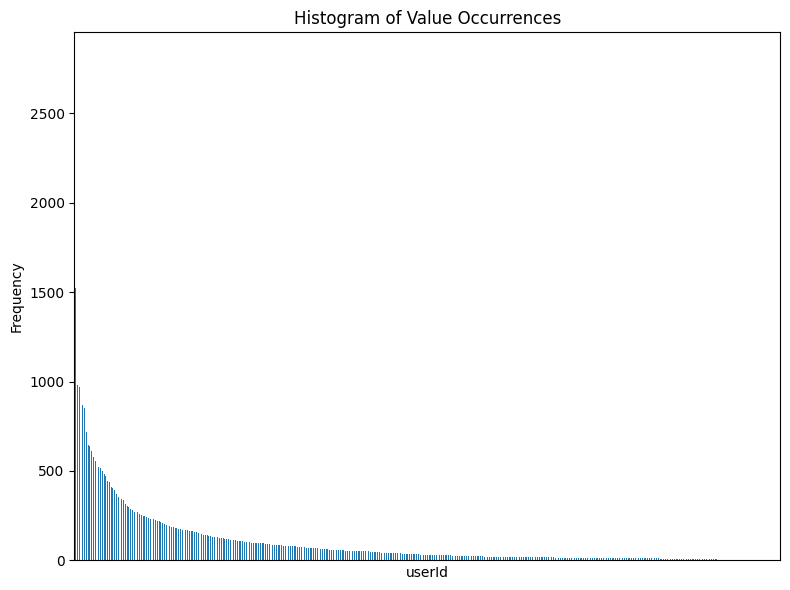

In [147]:
value_counts = ratings_sample['userId'].value_counts()
# Plotting the histogram
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar')
plt.xticks([])  # Hide x-axis labels
plt.ylabel('Frequency')
plt.title('Histogram of Value Occurrences')
plt.tight_layout()  # Adjust layout for better fit
plt.show()

In [148]:
ratings_sample.loc[:,'timestamp'] = ratings_sample['timestamp'].apply(lambda x: datetime.fromtimestamp(x))


#### User - User:

Recomienda películas que usuarios con gustos similares han disfrutado.

In [149]:
ratings_sample = pd.read_parquet("./input/ratings_sample.parquet")

In [150]:
pivot_user2user = ratings_sample.pivot_table(values='rating', index='userId', columns='movieId')


<Axes: xlabel='movieId', ylabel='userId'>

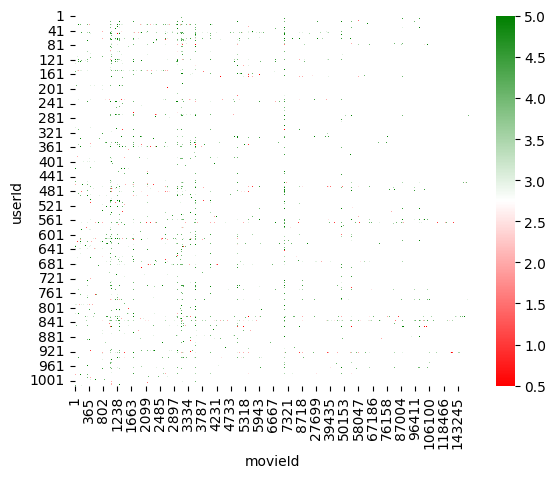

In [153]:
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
sns.heatmap(pivot_user2user,cmap=cmap)

In [154]:
ratings_dict = {}

for index, row in pivot_user2user.iterrows():
    user_ratings = row.dropna().to_dict()
    ratings_dict[index] = user_ratings

In [169]:
euclidean_similarity(ratings_dict,231,961)

0.015503875968992248

In [185]:
print("The top recommendations for the user are:")
recommend(ratings_dict, 231, 5, movies_metadata, euclidean_similarity)

The top recommendations for the user are:
+----------+-----------------+--------+
| Movie ID |      Title      | Rating |
+----------+-----------------+--------+
|   2694   | Tuya's Marriage |  5.0   |
+----------+-----------------+--------+


#### Item - Item:

Si a un usuario le gustó una pelicula, el sistema podría recomendar otras películas bien calificadas por aquellos que también disfrutaron esa pelicula.

In [200]:
recommend_similar_movies(ratings_dict, 38, movies_metadata)

Target Movie: 13008    Eternal Sunshine of the Spotless Mind
Name: title, dtype: object
+----------+-----------------------+------------+
| Movie ID |         Title         | Similarity |
+----------+-----------------------+------------+
|    11    |       Star Wars       |    1.0     |
|   350    | The Devil Wears Prada |    1.0     |
|   750    |    Murder She Said    |    1.0     |
+----------+-----------------------+------------+


### Model-Based Collaborative Filtering:

Implementa modelos de aprendizaje automático para predecir las preferencias del usuario.

Por ejemplo, utilizar un modelo de factorización de matrices para predecir las calificaciones de películas que un usuario aún no ha visto.

Se utiliza la libreía Surprise y se crea un objeto como dataset. Este dataset contiene los siguientes elementos:
1. Los IDs de los usuarios
2. Los IDs de cada pelicula.
3. El rating correspondiente, en una escala del 1 al 5

In [206]:
ratings_sample = pd.read_parquet('input/ratings_sample.parquet')

In [207]:
reader = Reader(rating_scale=(1, 5))  # Ajusta el rango de calificación según tus datos
data = Dataset.load_from_df(ratings_sample[['userId', 'movieId', 'rating']], reader)

In [209]:
train, test = train_test_split(ratings_sample, test_size=0.2, random_state=42)

trainset, testset = convert_traintest_dataframe_forsurprise(train, test)


#### Baseline Algorithm

In [ ]:
model = BaselineOnly()

recommendation(model,trainset,testset)

Estimating biases using als...
RMSE: 0.8666
MAE:  0.6696
Tiempo de Entrenamiento:  0.07677006721496582  segundos
Tiempo de Testeo:  0.03607606887817383  segundos


#### Matrix Factorization-based algorithms:

Singular Value Decomposition (SVD) es un algoritmo de factorización de matrices que puede utilizarse para sistemas de recomendación.

In [ ]:
model = SVD()

recommendation(model,trainset,testset)

RMSE: 0.8703
MAE:  0.6710
Tiempo de Entrenamiento:  0.6453449726104736  segundos
Tiempo de Testeo:  0.11665511131286621  segundos


SVDpp es una extension de SVD que tiene en cuenta ratings implicitos.

In [ ]:
model = SVDpp()

recommendation(model,trainset,testset)

RMSE: 0.8596
MAE:  0.6606
Tiempo de Entrenamiento:  20.293670177459717  segundos
Tiempo de Testeo:  3.7200539112091064  segundos


Non-Negative Matrix Factorization es un algoritmo de filtros colaborativos similar a SVD.

In [ ]:
model = NMF()

recommendation(model,trainset,testset)

RMSE: 0.9118
MAE:  0.7022
Tiempo de Entrenamiento:  1.1528229713439941  segundos
Tiempo de Testeo:  0.03983712196350098  segundos


##### Hyperparameter Tuning:
Se utiliza GridSearch para optimizar los modelos.

In [211]:
param_grid = {'n_factors':[25,50,100],
            'n_epochs': [5, 10, 20],
            'lr_all': [0.01, 0.02],
            'reg_all': [0.01,0.02]}

In [212]:
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
gs.fit(data)

# Imprime los hiperparametros optimos:
print("Modelo SVD con Hiperparametros: ", gs.best_params['rmse'])

# Imprime los resultados:
print('RMSE: ', gs.best_score['rmse'])
print('MAE: ', gs.best_score['mae'])


Modelo SVD con Hiperparametros:  {'n_factors': 25, 'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.02}
RMSE:  0.8677680941364427
MAE:  0.6670915607668395


In [214]:
modelSVD = SVD(**gs.best_params['rmse'])

recommendation(modelSVD,trainset,testset)

RMSE: 0.8649
MAE:  0.6664
Tiempo de Entrenamiento:  0.2677760124206543  segundos
Tiempo de Testeo:  0.041877031326293945  segundos


In [ ]:
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=5)
gs.fit(data)

# Imprime los hiperparametros optimos:
print("Modelo SVDpp con Hiperparametros: ", gs.best_params['rmse'])

# Imprime los resultados:
print('RMSE: ', gs.best_score['rmse'])
print('MAE: ', gs.best_score['mae'])


Modelo SVDpp con Hiperparametros:  {'n_factors': 25, 'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.01}
RMSE:  0.8614855182597019
MAE:  0.6606322400690552


In [ ]:
model = SVDpp(**gs.best_params['rmse'])

recommendation(model,trainset,testset)

RMSE: 0.8568
MAE:  0.6599
Tiempo de Entrenamiento:  8.685497999191284  segundos
Tiempo de Testeo:  2.964647054672241  segundos


#### Algoritmos de KNN

Algorimo basico de filtros colaborativos con KNNBasic.

In [ ]:
model = KNNBasic()

recommendation(model,trainset,testset)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9289
MAE:  0.7167
Tiempo de Entrenamiento:  0.06005096435546875  segundos
Tiempo de Testeo:  0.5675511360168457  segundos


Algoritmos basico de filtros colaborativos que tiene en cuenta el baseline rating.

In [ ]:
model = KNNBaseline()

recommendation(model,trainset,testset)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8699
MAE:  0.6668
Tiempo de Entrenamiento:  0.1260700225830078  segundos
Tiempo de Testeo:  0.8410758972167969  segundos


Algoritmos basico de filtros colaborativos que tiene en cuenta la media de ratings de cada usuario.

In [ ]:
model = KNNWithMeans()

recommendation(model,trainset,testset)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8873
MAE:  0.6798
Tiempo de Entrenamiento:  0.07488512992858887  segundos
Tiempo de Testeo:  0.6278090476989746  segundos


Algoritmos basico de filtros colaborativos que normaliza cada usuario.

In [ ]:
model = KNNWithZScore()

recommendation(model,trainset,testset)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8871
MAE:  0.6753
Tiempo de Entrenamiento:  0.10582232475280762  segundos
Tiempo de Testeo:  0.7064776420593262  segundos


##### Hyperparameter Tuning:

In [215]:
param_grid = {'k': [15, 20, 25, 30, 40, 50, 60]}

In [ ]:
knnbasic_gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnbasic_gs.fit(data)

knnbaseline_gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnbaseline_gs.fit(data)

knnmeans_gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnmeans_gs.fit(data)

knnz_gs = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnz_gs.fit(data)

In [217]:
# Imprime los hiperparametros optimos:
print("Modelo KNNBasic con Hiperparametros: ", knnbasic_gs.best_params['rmse'])

model = KNNBasic(**knnbasic_gs.best_params['rmse'])

recommendation(model,trainset,testset)

Modelo KNNBasic con Hiperparametros:  {'k': 20}
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9240
MAE:  0.7108
Tiempo de Entrenamiento:  0.08495402336120605  segundos
Tiempo de Testeo:  0.5252249240875244  segundos


In [218]:
# Imprime los hiperparametros optimos:
print("Modelo KNNBaseline con Hiperparametros: ", knnbaseline_gs.best_params['rmse'])

modelKNN = KNNBaseline(**knnbaseline_gs.best_params['rmse'])

recommendation(modelKNN,trainset,testset)

Modelo KNNBaseline con Hiperparametros:  {'k': 40}
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8699
MAE:  0.6668
Tiempo de Entrenamiento:  0.1474781036376953  segundos
Tiempo de Testeo:  0.6911959648132324  segundos


In [ ]:
# Imprime los hiperparametros optimos:
print("Modelo KNNWithMeans con Hiperparametros: ", knnmeans_gs.best_params['rmse'])

model = KNNWithMeans(**knnmeans_gs.best_params['rmse'])

recommendation(model,trainset,testset)

Modelo KNNWithMeans con Hiperparametros:  {'k': 50}
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8875
MAE:  0.6797
Tiempo de Entrenamiento:  0.06292414665222168  segundos
Tiempo de Testeo:  1.0611460208892822  segundos


In [ ]:
# Imprime los hiperparametros optimos:
print("Modelo KNNWithZScore con Hiperparametros: ", knnz_gs.best_params['rmse'])

model = KNNWithZScore(**knnz_gs.best_params['rmse'])

recommendation(model,trainset,testset)

Modelo KNNWithZScore con Hiperparametros:  {'k': 50}
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8872
MAE:  0.6752
Tiempo de Entrenamiento:  0.09295892715454102  segundos
Tiempo de Testeo:  0.6142218112945557  segundos


In [ ]:
x = [15, 20, 25, 30, 40, 50, 60]
y1 = knnbasic_gs.cv_results['mean_test_rmse']
y2 = knnbasic_gs.cv_results['mean_test_mae']

y3 = knnmeans_gs.cv_results['mean_test_rmse']
y4 = knnmeans_gs.cv_results['mean_test_mae']

y5 = knnz_gs.cv_results['mean_test_rmse']
y6 = knnz_gs.cv_results['mean_test_mae']

y7 = knnbaseline_gs.cv_results['mean_test_rmse']
y8 = knnbaseline_gs.cv_results['mean_test_mae']

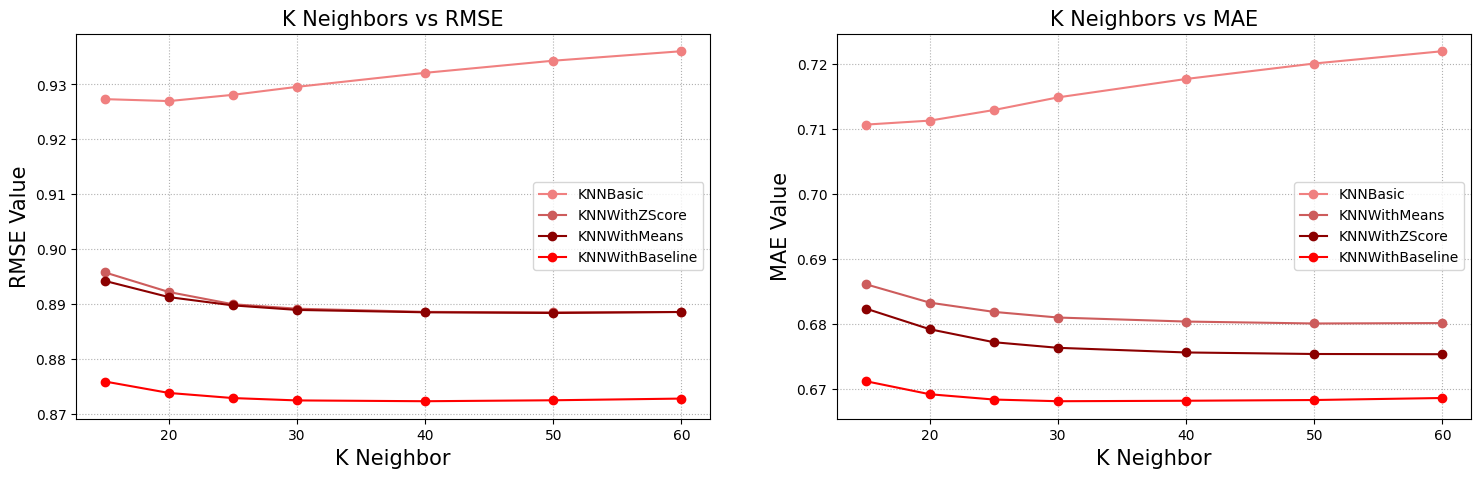

In [ ]:
plt.figure(figsize=(18,5))

plt.subplot(1, 2, 1)
plt.title('K Neighbors vs RMSE', loc='center', fontsize=15)
plt.plot(x, y1, label='KNNBasic', color='lightcoral', marker='o')
plt.plot(x, y5, label='KNNWithZScore', color='indianred', marker='o')
plt.plot(x, y3, label='KNNWithMeans', color='darkred', marker='o')
plt.plot(x, y7, label='KNNWithBaseline', color='red', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.subplot(1, 2, 2)
plt.title('K Neighbors vs MAE', loc='center', fontsize=15)
plt.plot(x, y2, label='KNNBasic', color='lightcoral', marker='o')
plt.plot(x, y4, label='KNNWithMeans', color='indianred', marker='o')
plt.plot(x, y6, label='KNNWithZScore', color='darkred', marker='o')
plt.plot(x, y8, label='KNNWithBaseline', color='red', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.show()

#### Evaluacion de Modelos:

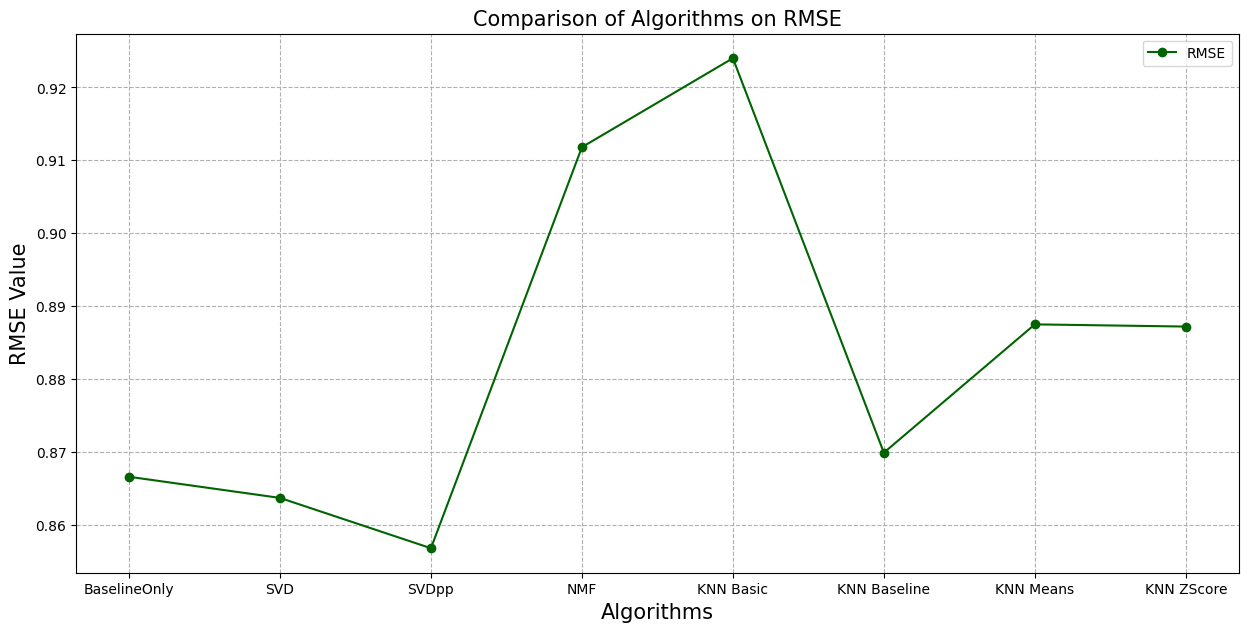

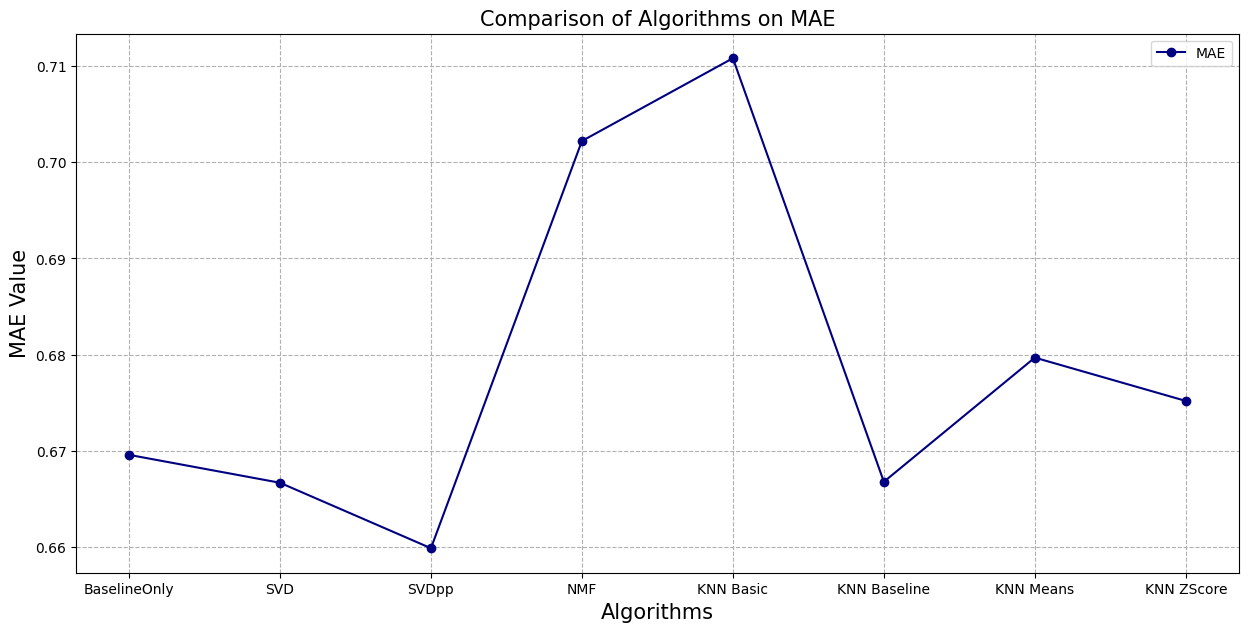

In [ ]:
modelos = ['BaselineOnly', 'SVD', 'SVDpp', 'NMF','KNN Basic','KNN Baseline', 'KNN Means', 'KNN ZScore']

rmse = [0.8666, 0.8637, 0.8568, 0.9118, 0.924,0.8699, 0.8875, 0.8872]
mae = [0.6696, 0.6667, 0.6599,0.7022,0.7108,0.6668,0.6797,0.6752]
fit_time = [0.2177, 0.64534, 8.6855,1.1528,0.05431,0.1165,0.0629,0.093]
test_time = [0.03608, 0.0455, 2.9646,0.0398,0.4113,0.62,1.0611,0.6142]

plt.figure(figsize=(15,7))

# plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(modelos, rmse, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')
plt.show()

# plt.subplot(1, 2, 2)
plt.figure(figsize=(15,7))
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(modelos, mae, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()

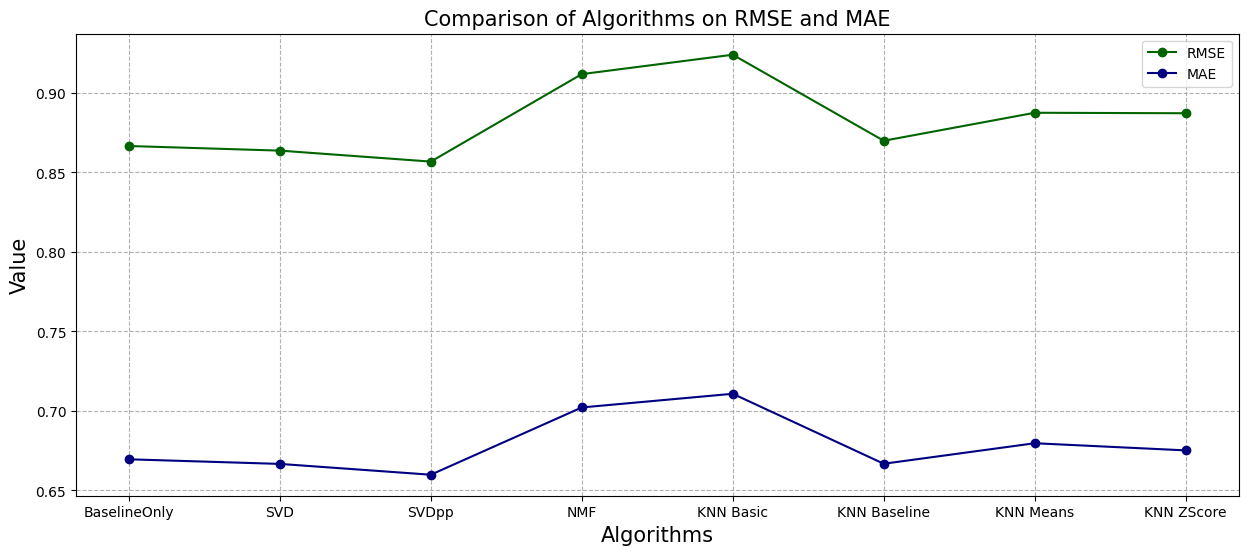

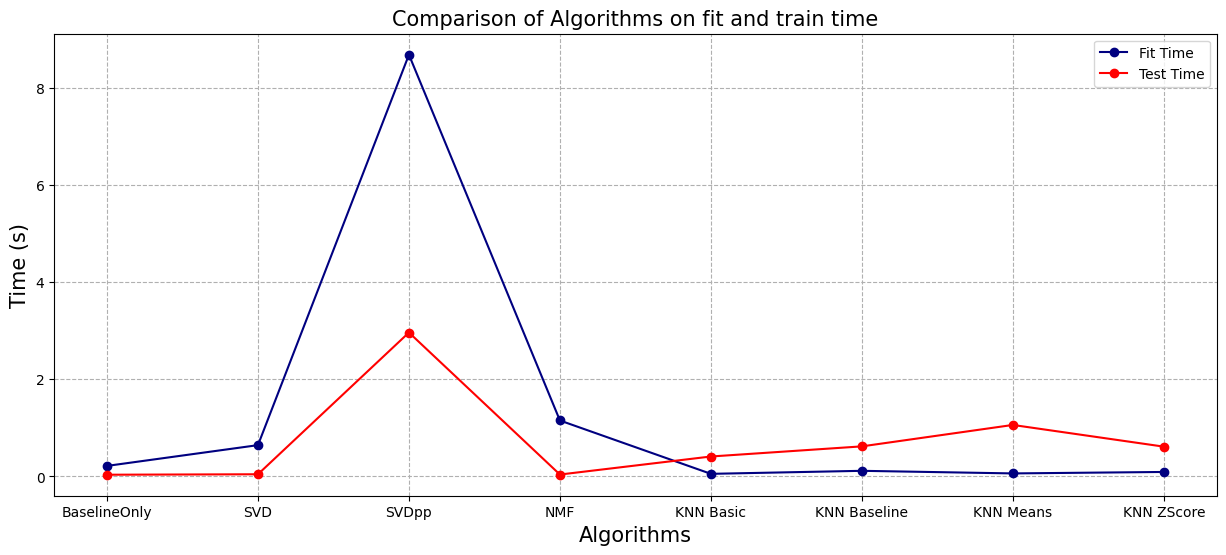

In [ ]:
plt.figure(figsize=(15,6))
plt.title('Comparison of Algorithms on RMSE and MAE', loc='center', fontsize=15)
plt.plot(modelos, rmse, label='RMSE', color='darkgreen', marker='o')
plt.plot(modelos, mae, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')
plt.show()


plt.figure(figsize=(15,6))
plt.title('Comparison of Algorithms on fit and train time', loc='center', fontsize=15)
plt.plot(modelos, fit_time, label='Fit Time', color='navy', marker='o')
plt.plot(modelos, test_time, label='Test Time', color='red', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('Time (s)', fontsize=15)
plt.legend()
plt.grid(ls='dashed')
plt.show()

Para concluir, el modelo mas productivo es el de **SVDpp** porque persenta el menor RMSE y MAE. Pero, tiene una alta diferencia de consumo computacional. Por lo que no es la mejor opcion.

Se decidio tomar como benchmark los modelos de **SVD** y **KNNBaseline**, estos presentan un RMSE comparable y consumen mucho menos tiempo de procesamiento.

In [220]:
dump.dump('modelSVD', algo=modelSVD)
dump.dump('modelKNN', algo=modelKNN)

In [221]:
# Se carga el dataset almacenado post EDA
movies = pd.read_parquet('./input/movies_final.parquet')

In [ ]:
movie_counts = ratings_sample['movieId'].value_counts()

In [223]:
movie_info = movies.loc[movies['id'] == 296]
movie_info

title  \
36843  Terminator 3: Rise of the Machines   

                                                overview release_date  \
36843  It's been 10 years since John Connor saved Ear...   2003-02-07   

       vote_average  vote_count                               genres   id  \
36843          5.90     2177.00  [Action, Thriller, Science Fiction]  296   

      original_language  popularity       budget  ...  \
36843                en       20.82 200000000.00  ...   

                               spoken_languages       profit    year  \
36843  [{'iso_639_1': 'en', 'name': 'English'}] 235000000.00 2003.00   

                                                    cast  \
36843  [Arnold Schwarzenegger, Nick Stahl, Claire Danes]   

                                                    crew         director  \
36843  [Don Burgess, Gale Anne Hurd, Gale Anne Hurd, ...  Jonathan Mostow   

      cast_size crew_size Unnamed: 0  \
36843        36       262    1580.00   

                                                keywords  
36843  [man vs machine, artificial intelligence (a.i....  

[1 rows x 30 columns]

Generar Recomendaciones

In [229]:
title, info = generate_recommendation(246, modelSVD, movies, 4)

In [230]:
print('Recomendacion: ', title)
info

Recomendacion:  The Million Dollar Hotel


[{'id': 318,
  'crew': array(['Wim Wenders', 'Nicholas Klein', 'Bono', 'Bono', 'Wim Wenders',
         'Bruce Davey', 'Nicholas Klein', 'Deepak Nayar', 'Ulrich Felsberg',
         'Tatiana S. Riegel', 'Phedon Papamichael', 'Robbie Freed',
         'Tiffany Payne', 'Nancy Steiner'], dtype=object),
  'director': 'Wim Wenders',
  'title': 'The Million Dollar Hotel',
  'genres': array(['Drama', 'Thriller'], dtype=object)}]

### Hybrid Recommender:

Combinación de varias técnicas, por ejemplo, usando tanto recomendaciones basadas en contenido como colaborativas.

Por ejemplo, podría sugerir películas basadas en los géneros preferidos del usuario y también en lo que usuarios similares han visto.

In [231]:
ratings_sample = pd.read_parquet('./input/ratings_sample.parquet')

In [233]:
movies_filtered = movies[['id','title','genres']]

In [235]:
movies_with_genre = pd.merge(ratings_sample, movies_filtered, left_on='movieId', right_on='id', how='left')
movies_with_genre = movies_with_genre[~pd.isnull(movies_with_genre['id'])]


In [236]:
train, test = train_test_split(movies_with_genre, test_size=0.2, random_state=42)
trainset, testset = convert_traintest_dataframe_forsurprise(train, test)

In [239]:
_, modelKNN = dump.load('Modelos/modelKNN')
recommendation(modelKNN,trainset,testset)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8736
MAE:  0.6721
Tiempo de Entrenamiento:  0.060105085372924805  segundos
Tiempo de Testeo:  0.31641602516174316  segundos


In [240]:
_, modelSVD = dump.load('Modelos/modelSVD')
recommendation(modelSVD,trainset,testset)

RMSE: 0.8699
MAE:  0.6705
Tiempo de Entrenamiento:  0.09405279159545898  segundos
Tiempo de Testeo:  0.017771005630493164  segundos


In [58]:
movies['tagline'] = movies['tagline'].fillna('')
movies['description_genre'] = movies['overview'] + movies['tagline'] + 2*movies['genres']
movies['description_genre'] = movies['description_genre'].fillna('')

In [63]:
tf_new = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0.0, stop_words='english')

text_data = movies['description_genre'].astype(str).tolist()

# Fit and transform the text data
tfidf_matrix_new = tf_new.fit_transform(text_data)

In [64]:
cosine_sim_new = linear_kernel(tfidf_matrix_new, tfidf_matrix_new)

In [87]:
movies = movies.reset_index()
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])
indices.head(2)

title
!Women Art Revolution    0
#1 Cheerleader Camp      1
dtype: int64

In [88]:
def get_recommendations_new(title):
    idx = indices[title]
    if type(idx) != np.int64:
        if len(idx)>1:
            print("ALERT: Multiple values")
            idx = idx[0]
    sim_scores = list(enumerate(cosine_sim_new[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return movies['movieId'].iloc[movie_indices]

In [73]:
movies_filtered = movies[['id','title','genres']]

df_sorted = movies_filtered.sort_values(by='id')

df_sorted

            id                title                                genres
3283         2                Ariel                        [Drama, Crime]
29568        3  Shadows in Paradise                       [Drama, Comedy]
12958        5           Four Rooms                       [Crime, Comedy]
18111        6       Judgment Night             [Action, Thriller, Crime]
31236       11            Star Wars  [Adventure, Action, Science Fiction]
...        ...                  ...                                   ...
19090  1203385       L'Albume D'Oro                                    []
33888  1203393           The Burden                         [Documentary]
481    1203440          5 Feet Away                               [Drama]
34131  1203564  The Choice Is Yours                         [Documentary]
19192  1203973       La Distraction                       [Comedy, Drama]

[45620 rows x 3 columns]


In [78]:
movies_with_genre = pd.merge(ratings_sample, movies_filtered, left_on='movieId', right_on='id', how='left')


In [85]:
unique_genre = movies_with_genre['genres'].explode().unique()

# Get the count of each genre
genre_distribution = movies_with_genre['genres'].explode().value_counts()

# Make a dict assigning an index to a genre
genre_dict = {k: v for v, k in enumerate(unique_genre)}


{'Drama': 0,
 'Mystery': 1,
 'Romance': 2,
 'Comedy': 3,
 nan: 4,
 'Crime': 5,
 'Action': 6,
 'Foreign': 7,
 'Documentary': 8,
 'War': 9,
 'Adventure': 10,
 'Fantasy': 11,
 'Thriller': 12,
 'Science Fiction': 13,
 'Horror': 14,
 'History': 15,
 'Music': 16,
 'Family': 17,
 'Western': 18,
 'TV Movie': 19,
 'Animation': 20}

In [ ]:
user_ids = movies_with_genre['userId'].unique()
user_df = pd.DataFrame(columns=['userId', 'user_vector', 'avg_rating', 'num_movies_rated'])

for user_id in user_ids:
    print(user_id)
    user_rating_df = movies_with_genre[(movies_with_genre['userId'] == user_id)]
    print(user_rating_df)

    user_vector = np.zeros(len(genre_dict))
    count_vector = np.zeros(len(genre_dict))
    
    user_avg_rating = 0
    movies_rated_count = 0
    
    for _, row in user_rating_df.iterrows():
        user_avg_rating += row.rating 
        movies_rated_count += 1
        genres = row.genres
        
        # Check if genres is a float (non-iterable)
        if not isinstance(genres, float):
            user_movie_vector = np.zeros(len(genre_dict))
            
            for g in genres:
                user_movie_vector[genre_dict[g]] = 1
                count_vector[genre_dict[g]] += 1

            user_vector += user_movie_vector * row.rating

    count_vector = np.where(count_vector == 0, 1, count_vector)
    user_vector = np.divide(user_vector, count_vector)
    user_avg_rating /= movies_rated_count
    row_df = pd.DataFrame([[user_id, user_vector, user_avg_rating, movies_rated_count]], 
                          columns=['userId', 'user_vector', 'avg_rating', 'num_movies_rated'])
    user_df = pd.concat([user_df, row_df], ignore_index=True)

Popularity model

In [132]:
def genre_based_popularity(genre):
    mask = movies_with_genre.genres.apply(lambda x: genre in x)
    filtered_movie = movies_with_genre[mask]
    filtered_movie = filtered_movie.sort_values(by='popularity', ascending=False)
#     filtered_movie = filtered_movie.sort_values(by='wr', ascending=False)
    return filtered_movie['movieId'].head(10).values.tolist() 

In [133]:
user_df['user_vector'] = user_df['user_vector'].apply(lambda x: np.array_str(x))
user_df['user_vector'] = user_df['user_vector'].apply(lambda x: x.replace('[', ' ').replace(']', ' ').strip().split())
user_df['user_vector'] = user_df['user_vector'].apply(lambda x: np.asarray(x).astype(float))

In [134]:
def user_top_genre(userId):
    user_vec = user_df['user_vector'][user_df['userId'] == userId].values[0].copy()
    top_genre_indices = np.flip(np.argsort(user_vec))
    genre_list = []
    for i in top_genre_indices[:3]:
        genre_list.append(idx_to_genre[i])
    return genre_list

In [135]:
user_top_genre(1)


['Crime', 'Romance', 'Comedy']

Hybrid Model

In [136]:
knn_baseline = dump.load('KnnBaseline_model')
svdpp = dump.load('svd_model') 

In [137]:
# List of users in testing data:
user_list = test['userId'].unique()

In [138]:
test_movies = test[test['userId'] == 60]
test_movies.head()

userId  movieId  rating   timestamp       id  \
5924      60     1252     4.0  1136304311   1252.0   
5915      60      714     5.0  1136307133    714.0   
5908      60      168     0.5  1136304366    168.0   
5998      60    27905     4.0  1136306150  27905.0   
5940      60     1986     0.5  1136305753   1986.0   

                              title                             genres  
5924                  Lonely Hearts  [Drama, Thriller, Crime, Romance]  
5915            Tomorrow Never Dies      [Adventure, Action, Thriller]  
5908  Star Trek IV: The Voyage Home       [Science Fiction, Adventure]  
5998          Island of the Fishmen          [Science Fiction, Horror]  
5940                Live and Become                            [Drama]

In [144]:
# Combined model predicion on testing data, using top movies to generate more movies based on movie similarity and popularity

def hybrid(userId):
    user_movies = test[test['userId'] == userId]
    user_movies['est'] = user_movies['movieId'].apply(lambda x: 0.6*knnbaseline_algo.predict(userId,x).est + 0.4*svdpp_algo.predict(userId, x).est)    
    user_movies = user_movies.sort_values(by ='est', ascending=False).head(4)
    user_movies['Model'] = 'SVD + CF'
#     user_movies = user_movies['movieId'].values.tolist()
#     print("User liked movies list: ", user_movies)
    
    recommend_list = user_movies[['movieId', 'est', 'Model']]
    print(recommend_list.head())

#     top_movie = user_movies['movieId'].iloc[0]
#     print("Top movie id", top_movie)
#     top_movie_title = movies['title'][movies['movieId'] == top_movie].values[0]
#     print("Top movie title", top_movie_title)

    movie_list = recommend_list['movieId'].values.tolist()
    print(movie_list)
    sim_movies_list = []
    for movie_id in movie_list:
        # Call content based 
        movie_title = movies_with_genre['title'][movies_with_genre['movieId'] == movie_id].values[0]
        sim_movies = get_recommendations_new(movie_title)
#         print(sim_movies.values.tolist())
        sim_movies_list.extend(sim_movies)
    
    
    # Compute ratings for the popular movies
    for movie_id in sim_movies_list:
        pred_rating = 0.6*knnbaseline_algo.predict(userId, movie_id).est + 0.4*svdpp_algo.predict(userId, movie_id).est
        row_df = pd.DataFrame([[movie_id, pred_rating, 'Movie similarity']], columns=['movieId', 'est','Model'])
        recommend_list = pd.concat([recommend_list, row_df], ignore_index=True)
    
    # Popular based movies
    top_genre_list = user_top_genre(userId)
    print("User top genre list: ", top_genre_list)
    
    popular_movies = []
    for top_genre in top_genre_list:
        popular_movies.extend(genre_based_popularity(top_genre))
    print("Final list: ", popular_movies)
    
    # Compute ratings for the popular movies
    for movie_id in popular_movies:
        pred_rating = 0.6*knnbaseline_algo.predict(userId, movie_id).est + 0.4*svdpp_algo.predict(userId, movie_id).est
        row_df = pd.DataFrame([[movie_id, pred_rating, 'Popularity']], columns=['movieId', 'est','Model'])
        recommend_list = pd.concat([recommend_list, row_df], ignore_index=True)
    recommend_list = recommend_list.drop_duplicates(subset=['movieId'])
    train_movie_list = train[train['userId']==userId]['movieId'].values.tolist()
    
    # Remove movies in training for this user
    mask = recommend_list.movieId.apply(lambda x: x not in train_movie_list)
    recommend_list = recommend_list[mask]
    
    return recommend_list

In [141]:
train[train['userId'] == 524].sort_values(by = 'rating', ascending = False)


userId  movieId  rating  timestamp     id  \
49683     524       95     5.0  847140395   95.0   
49755     524      588     5.0  847140091  588.0   
49717     524      316     5.0  847140116  316.0   
49746     524      500     5.0  847140217  500.0   
49706     524      253     5.0  847140190  253.0   
49747     524      508     5.0  847140422  508.0   
49763     524      780     5.0  847140505  780.0   
49752     524      552     5.0  847140559  552.0   
49673     524       11     5.0  847140344   11.0   
49744     524      480     5.0  847140143  480.0   
49686     524      150     5.0  847140028  150.0   
49671     524        2     5.0  847140344    2.0   
49733     524      380     5.0  847140028  380.0   
49754     524      587     5.0  847140240  587.0   
49765     524      805     5.0  847140585  805.0   
49684     524      110     5.0  847140190  110.0   
49749     524      527     5.0  847140283  527.0   
49685     524      141     5.0  847140395  141.0   
49734     524      410     4.0  847140240  410.0   
49759     524      594     4.0  847140559  594.0   
49718     524      317     4.0  847140305  317.0   
49700     524      224     4.0  847140505  224.0   
49710     524      280     4.0  847140534  280.0   
49757     524      590     4.0  847140028  590.0   
49701     524      225     4.0  847140261  225.0   
49760     524      595     4.0  847140116  595.0   
49729     524      364     4.0  847140217  364.0   
49715     524      300     4.0  847140240  300.0   
49742     524      457     4.0  847140091  457.0   
49707     524      261     4.0  847140559  261.0   
49725     524      350     4.0  847140344  350.0   
49721     524      337     4.0  847140422  337.0   
49709     524      273     4.0  847140585  273.0   
49764     524      786     4.0  847140559  786.0   
49739     524      440     4.0  847140305  440.0   
49692     524      165     4.0  847140091  165.0   
49751     524      551     4.0  847140585  551.0   
49724     524      349     4.0  847140116  349.0   
49714     524      296     3.0  847140028  296.0   
49705     524      252     3.0  847140459  252.0   
49674     524       19     3.0  847140261   19.0   
49675     524       21     3.0  847140261   21.0   
49738     524      435     3.0  847140305  435.0   
49720     524      329     3.0  847140143  329.0   
49697     524      196     3.0  847140422  196.0   
49703     524      235     3.0  847140459  235.0   
49722     524      339     3.0  847140167  339.0   
49696     524      186     3.0  847140459  186.0   
49691     524      161     3.0  847140167  161.0   
49740     524      442     3.0  847140368  442.0   
49716     524      315     3.0  847140368  315.0   
49690     524      160     3.0  847140305  160.0   
49695     524      185     3.0  847140167  185.0   
49723     524      344     2.0  847140091  344.0   
49702     524      231     1.0  847140116  231.0   

                                     title  \
49683                           Armageddon   
49755                          Silent Hill   
49717                          Grill Point   
49746                       Reservoir Dogs   
49706                     Live and Let Die   
49747                        Love Actually   
49763           The Passion of Joan of Arc   
49752                     Bread and Tulips   
49673                            Star Wars   
49744                      Monsoon Wedding   
49686                              48 Hrs.   
49671                                Ariel   
49733                             Rain Man   
49754                             Big Fish   
49765                      Rosemary's Baby   
49684                    Three Colors: Red   
49749                   Once Were Warriors   
49685                         Donnie Darko   
49734                     Summer in Berlin   
49759                         The Terminal   
49718      Grbavica: The Land of My Dreams   
49700                        Man of Marble   
49710           Terminator 2: Judgme

In [142]:
test[test['userId'] == 574]


userId  movieId  rating   timestamp       id  \
55112     574      296     4.5  1430450552    296.0   
55138     574     3175     4.0  1430450999   3175.0   
55162     574     6373     4.0  1430450224   6373.0   
55150     574     4973     4.0  1430449916   4973.0   
55186     574    58559     4.0  1430449926  58559.0   
55175     574    26662     5.0  1430449700  26662.0   

                                              title  \
55112            Terminator 3: Rise of the Machines   
55138                                  Barry Lyndon   
55162                       The Very Thought of You   
55150                                Under the Sand   
55186          Confession of a Child of the Century   
55175  Detective Conan: The Phantom of Baker Street   

                                    genres  
55112  [Action, Thriller, Science Fiction]  
55138                [Drama, Romance, War]  
55162                    [Comedy, Romance]  
55150                     [Drama, Mystery]  
55186                              [Drama]  
55175      [Animation, Adventure, Mystery]

In [161]:
test['userId']

34249     387
10309     120
59852     625
6801       65
98402     990
         ... 
99832    1012
11333     132
21984     251
87249     877
28486     340
Name: userId, Length: 7980, dtype: int64

In [163]:
hybrid(524)

/var/folders/9k/p0fvsltn31bgmv55mws4vsnr0000gn/T/ipykernel_1497/4023297354.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_movies['est'] = user_movies['movieId'].apply(lambda x: 0.6*knnbaseline_algo.predict(userId,x).est + 0.4*svdpp_algo.predict(userId, x).est)


       movieId       est     Model
49719      318  4.900765  SVD + CF
49682       62  4.315467  SVD + CF
49753      553  4.295726  SVD + CF
49708      266  4.256260  SVD + CF
[318, 62, 553, 266]


KeyError: 'movieId'

# Deploy:

In [27]:
import pandas as pd
import shelve
import pickle
import seaborn as sns
import requests
from flask import  Flask
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

Creamos una aplicación para recomendar peliculas similares a un input

In [28]:
app = Flask('Modelo Peliculas')

In [61]:
models = {
    'recommend_similar_movies': recommend_similar_movies
}

In [62]:
with shelve.open('models_db') as db:
    db['models'] = models

In [63]:
@app.route("/", methods=['GET'])
def hello():
    alive = "La app está viva"
    return alive

@app.route("/predict/<movie>", methods=['GET'])
def predictSales(movie):
#     s = shelve.open("../Data/handson_model.db")
#     model = s["model"]
    
    with shelve.open('models_db') as db:
        stored_functions = db['models'] 
    
    recommend_similar_movies = stored_functions['recommend_similar_movies']()

    
    
    # The return type must be a string, dict, tuple, Response instance, or WSGI callable
    result = {"Recommendations": recommend_similar_movies(movie)}
    return result

In [64]:
app.run(host='0.0.0.0', port = 5017)

 * Serving Flask app 'Modelo Peliculas'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5017
 * Running on http://192.168.0.37:5017
Press CTRL+C to quit
127.0.0.1 - - [28/Nov/2023 17:44:24] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2023 17:44:38] "GET /favicon.ico HTTP/1.1" 404 -
192.168.0.37 - - [28/Nov/2023 17:44:48] "GET / HTTP/1.1" 200 -
192.168.0.37 - - [28/Nov/2023 17:44:52] "GET /favicon.ico HTTP/1.1" 404 -


In [ ]:
recommend_similar_movies